## RMS visualizer

This is a graphic tool to help to determine the adequate detection limit value for a collection of VLBI intensity maps. Plase check the READ-ME.md and main_usage.ipynb files to know how the treeshold values determines the detection limit. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib ; import matplotlib.pyplot as plt ; import matplotlib as mpl ; from matplotlib import colors ; import matplotlib.patches as mpatches
import matplotlib.ticker as ticker ; from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import warnings
from astropy.io.fits.verify import VerifyWarning ; from astropy.io import fits ; from astropy.stats import SigmaClip
import photutils as phot ; from photutils.background import Background2D, MMMBackground
from pathlib import Path
import glob
import re
warnings.simplefilter("ignore",VerifyWarning)

def Contours(l1,b):
    return l1*np.power(2,b)

As in 'demo.ipynb', this operates over a list of .fits maps to be fitted and a list of the folders were they are placed. Here we provided the list of 3C 279 maps, however you can change to read the 3C 454.3 maps list.

In [2]:
folders_3C279 = pd.read_csv(f'../data/3C_279/folder_list.txt',header=None) ;  folders_3C279 = folders_3C279[0].tolist() ; display(folders_3C279)
files_3C279 = pd.read_csv(f'../data/3C_279/files_list.txt',header=None) ;  files_3C279 = files_3C279[0].tolist() ; display(files_3C279)

['../data/3C_279/2008-06-12',
 '../data/3C_279/2009-05-30',
 '../data/3C_279/2010-04-10',
 '../data/3C_279/2011-07-21',
 '../data/3C_279/2012-03-05',
 '../data/3C_279/2013-05-30',
 '../data/3C_279/2014-07-28',
 '../data/3C_279/2015-09-22',
 '../data/3C_279/2016-07-31',
 '../data/3C_279/2017-03-19']

['../data/3C_279/2008-06-12/3C279JUN08.IMAP',
 '../data/3C_279/2009-05-30/3C279MAY09.IMAP',
 '../data/3C_279/2010-04-10/3C279APR10E.IMAP',
 '../data/3C_279/2011-07-21/3C279JUL11.IMAP',
 '../data/3C_279/2012-03-05/3C279MAR12.IMAP',
 '../data/3C_279/2013-05-30/3C279MAY13.IMAP',
 '../data/3C_279/2014-07-28/3C279JUL14.IMAP',
 '../data/3C_279/2015-09-22/3C279SEP15.IMAP',
 '../data/3C_279/2016-07-31/3C279AUG16.IMAP',
 '../data/3C_279/2017-03-19/3C279MAR17.IMAP']

Here, the background noise distribution is estimated for each map on the list, along with the RMS distribution associated to the background. Several detection limits values are computed by the product of sigma levels and the median RMS. The sigma levels are 6,7,8,9,10, and 12. You can change the numbers on the file denoted with a comment. The visualization of the map, background, RMS, and detected sources in a grid of subplots are directly showed in the notebook and also saved in a folder inside the source carpet. For a complete description about the detection limit estimation please read Amador-Portes et al. (2025b).

File: ../data/3C_279/2008-06-12/3C279JUN08.IMAP
Date: 2008-06-12


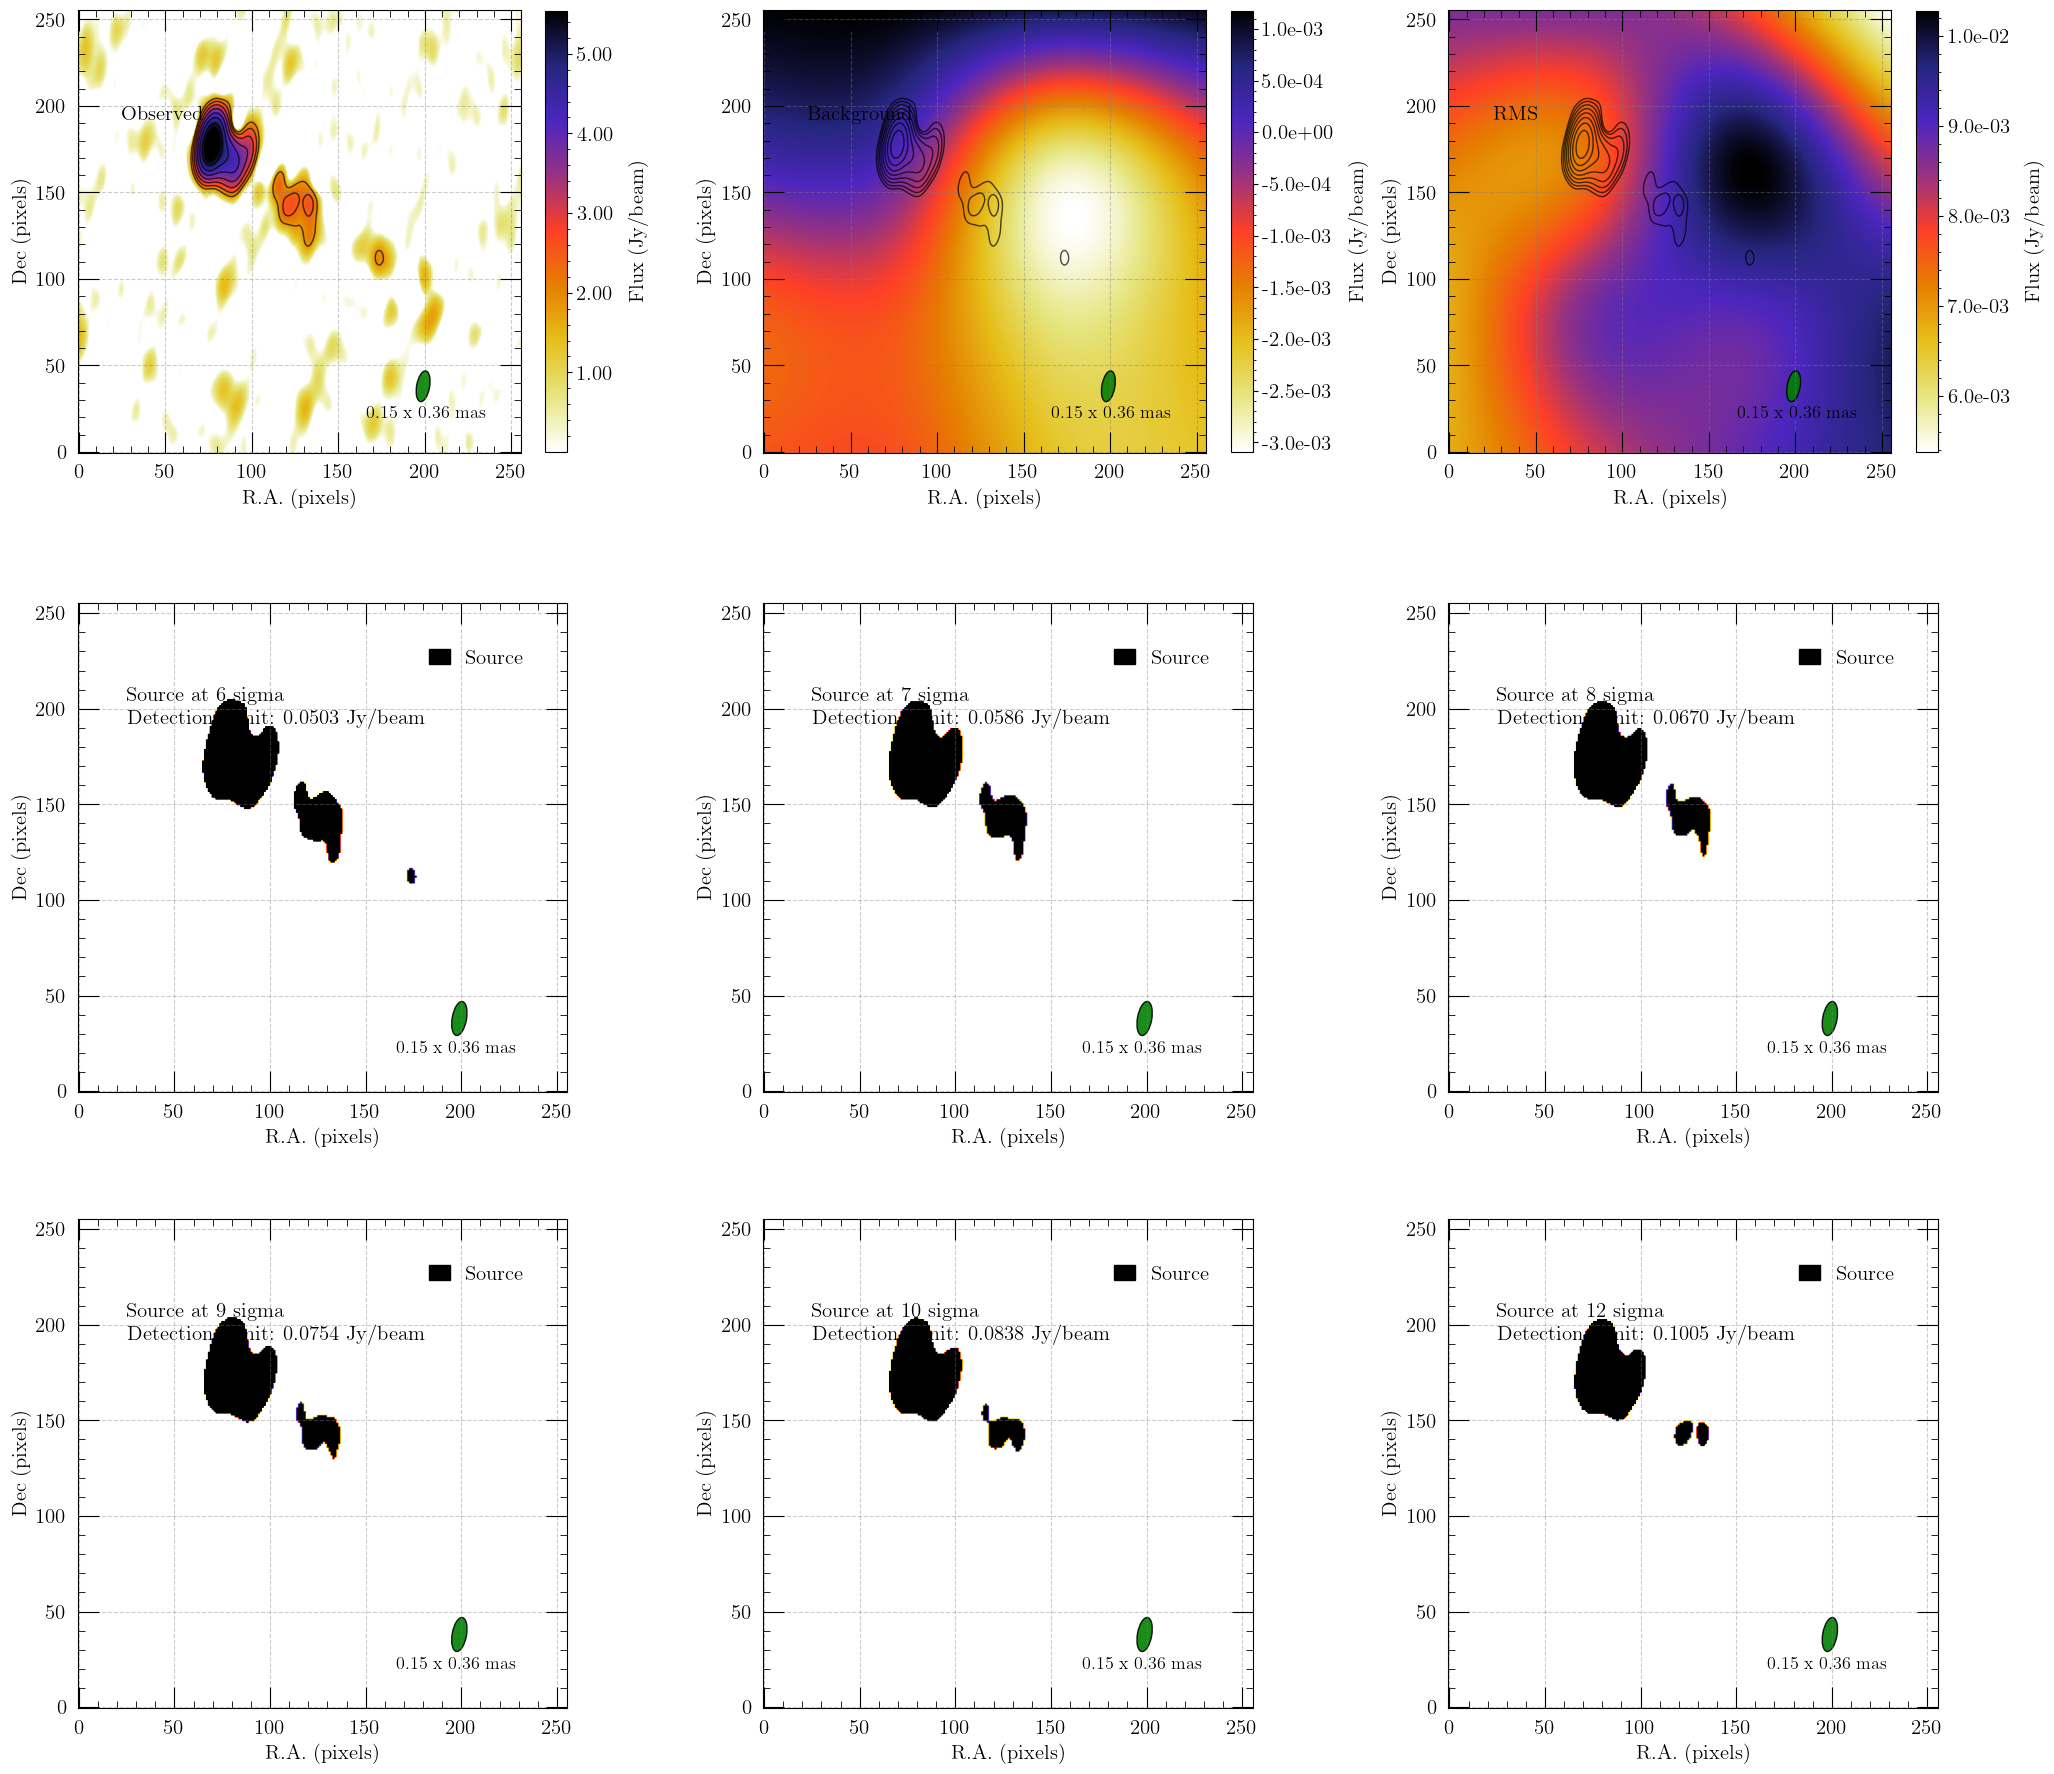

File: ../data/3C_279/2009-05-30/3C279MAY09.IMAP
Date: 2009-05-30


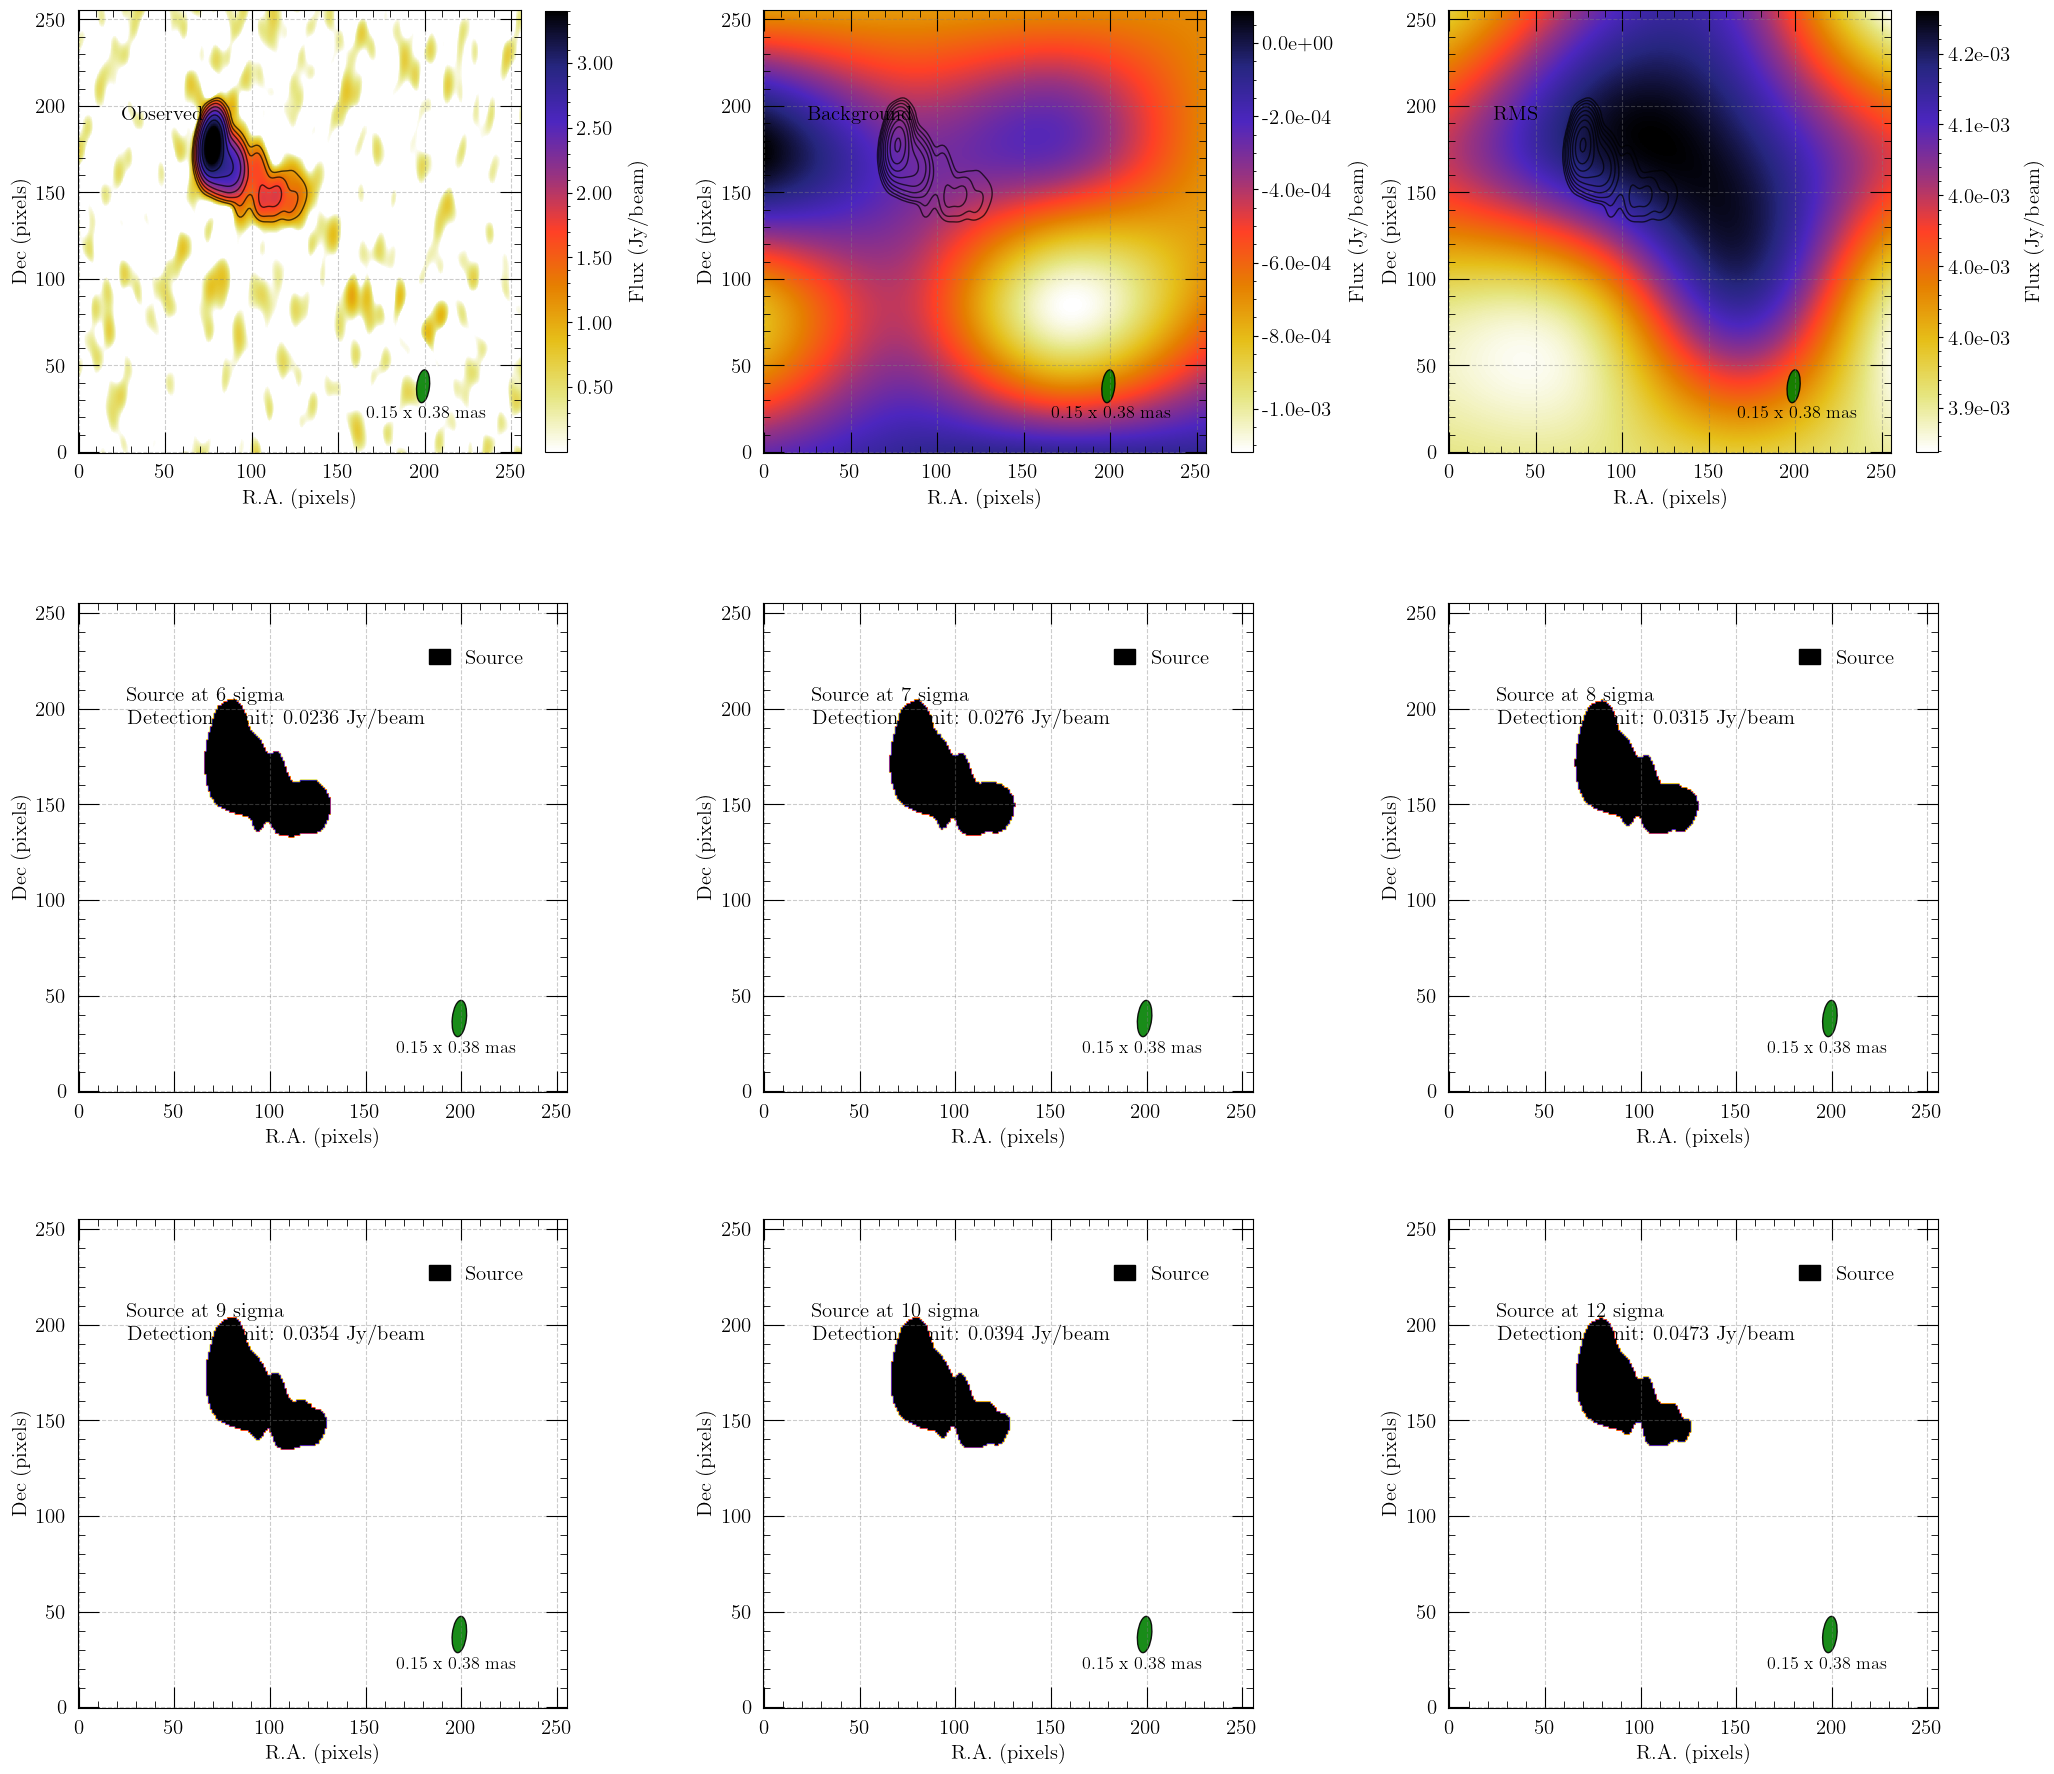

File: ../data/3C_279/2010-04-10/3C279APR10E.IMAP
Date: 2010-04-10


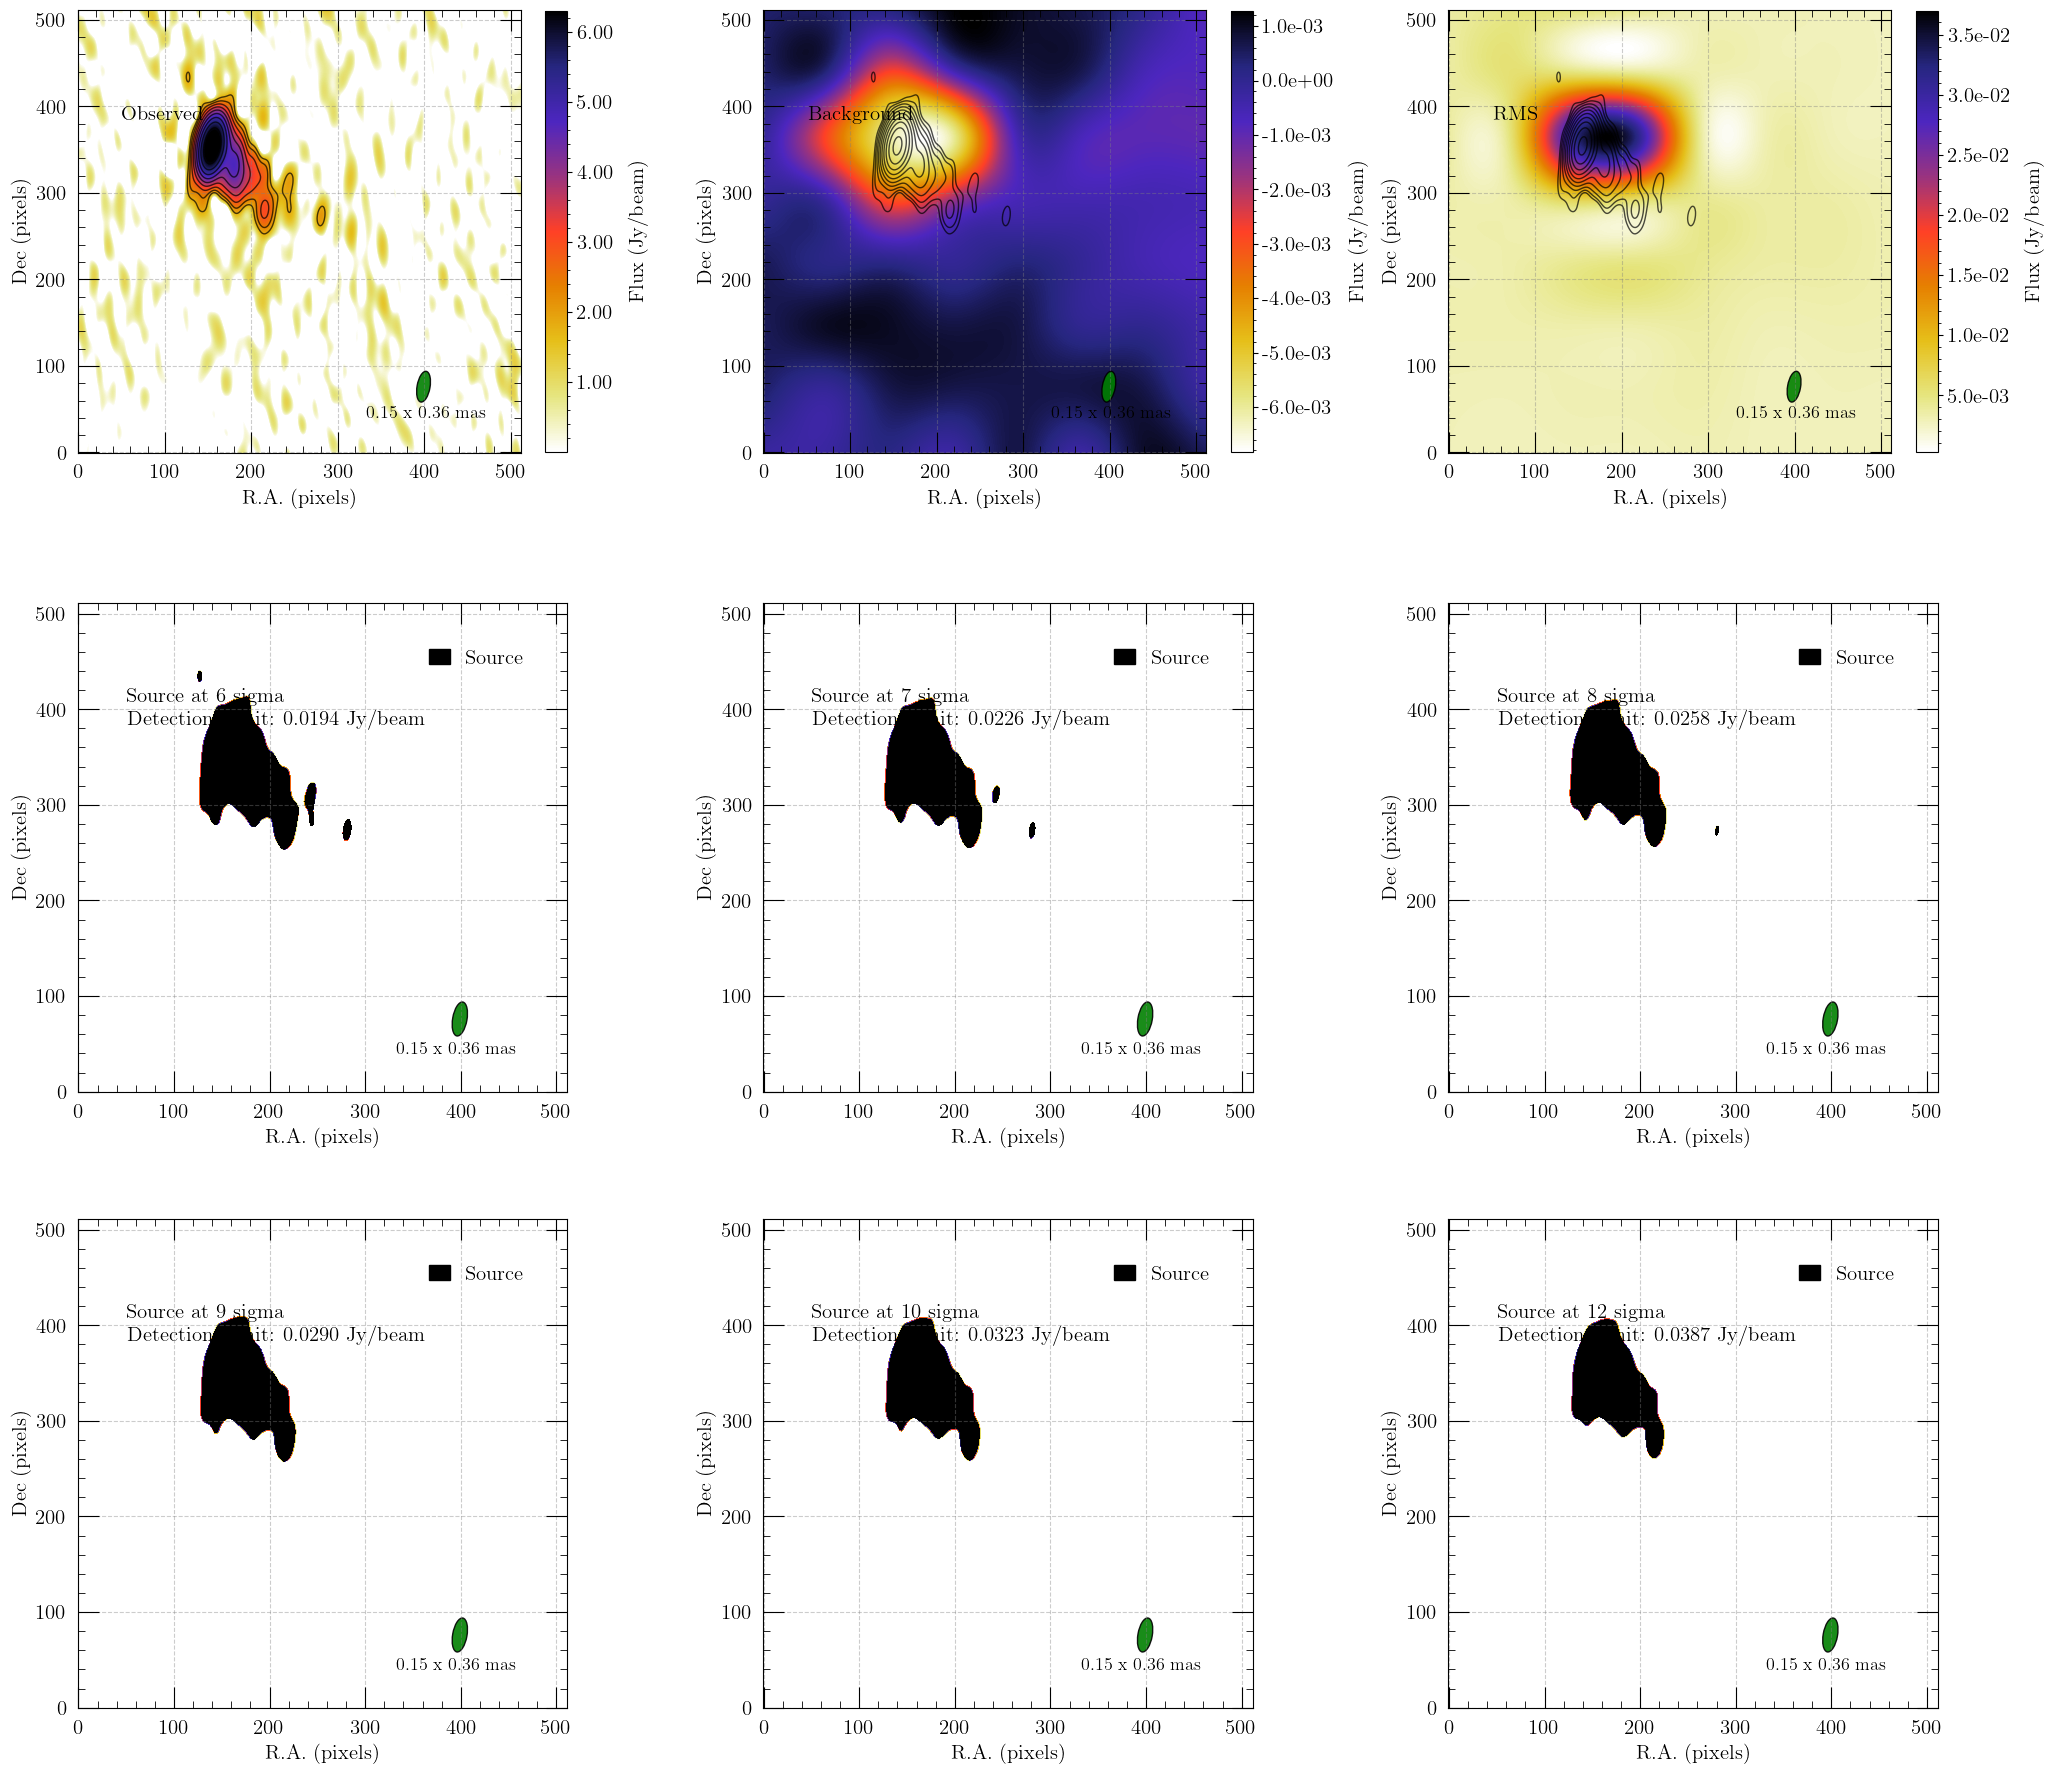

File: ../data/3C_279/2011-07-21/3C279JUL11.IMAP
Date: 2011-07-21


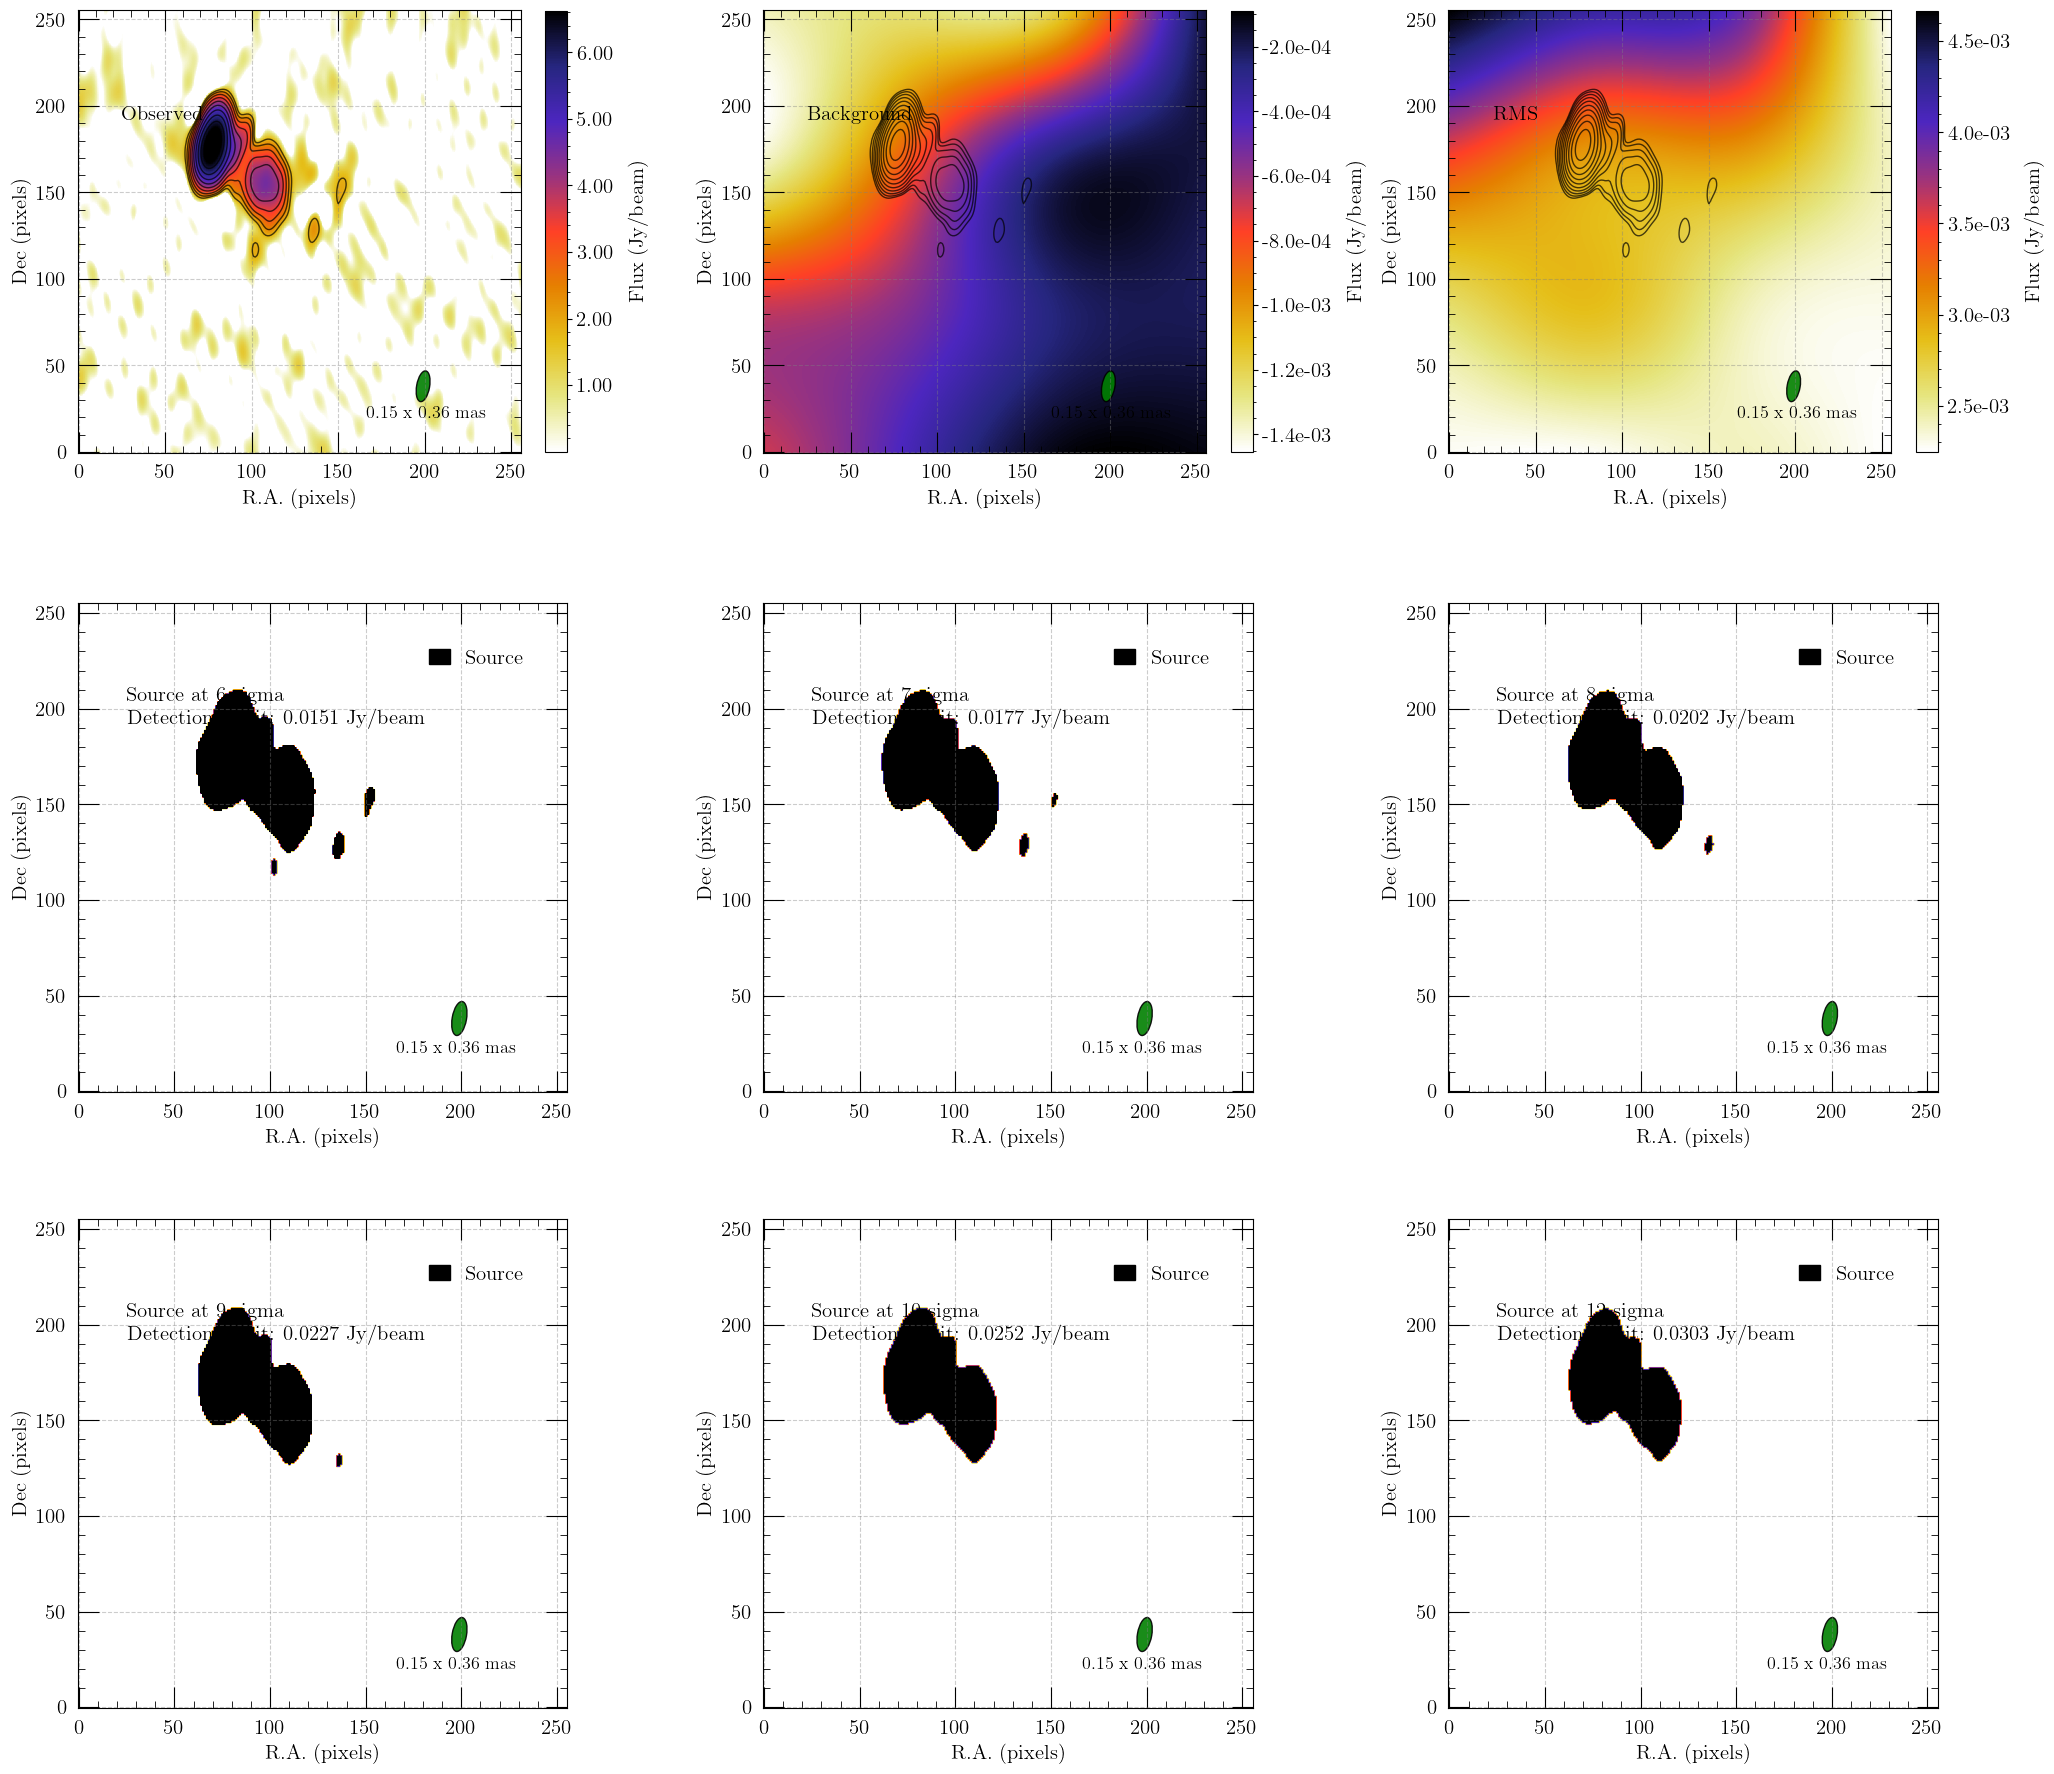

File: ../data/3C_279/2012-03-05/3C279MAR12.IMAP
Date: 2012-03-05


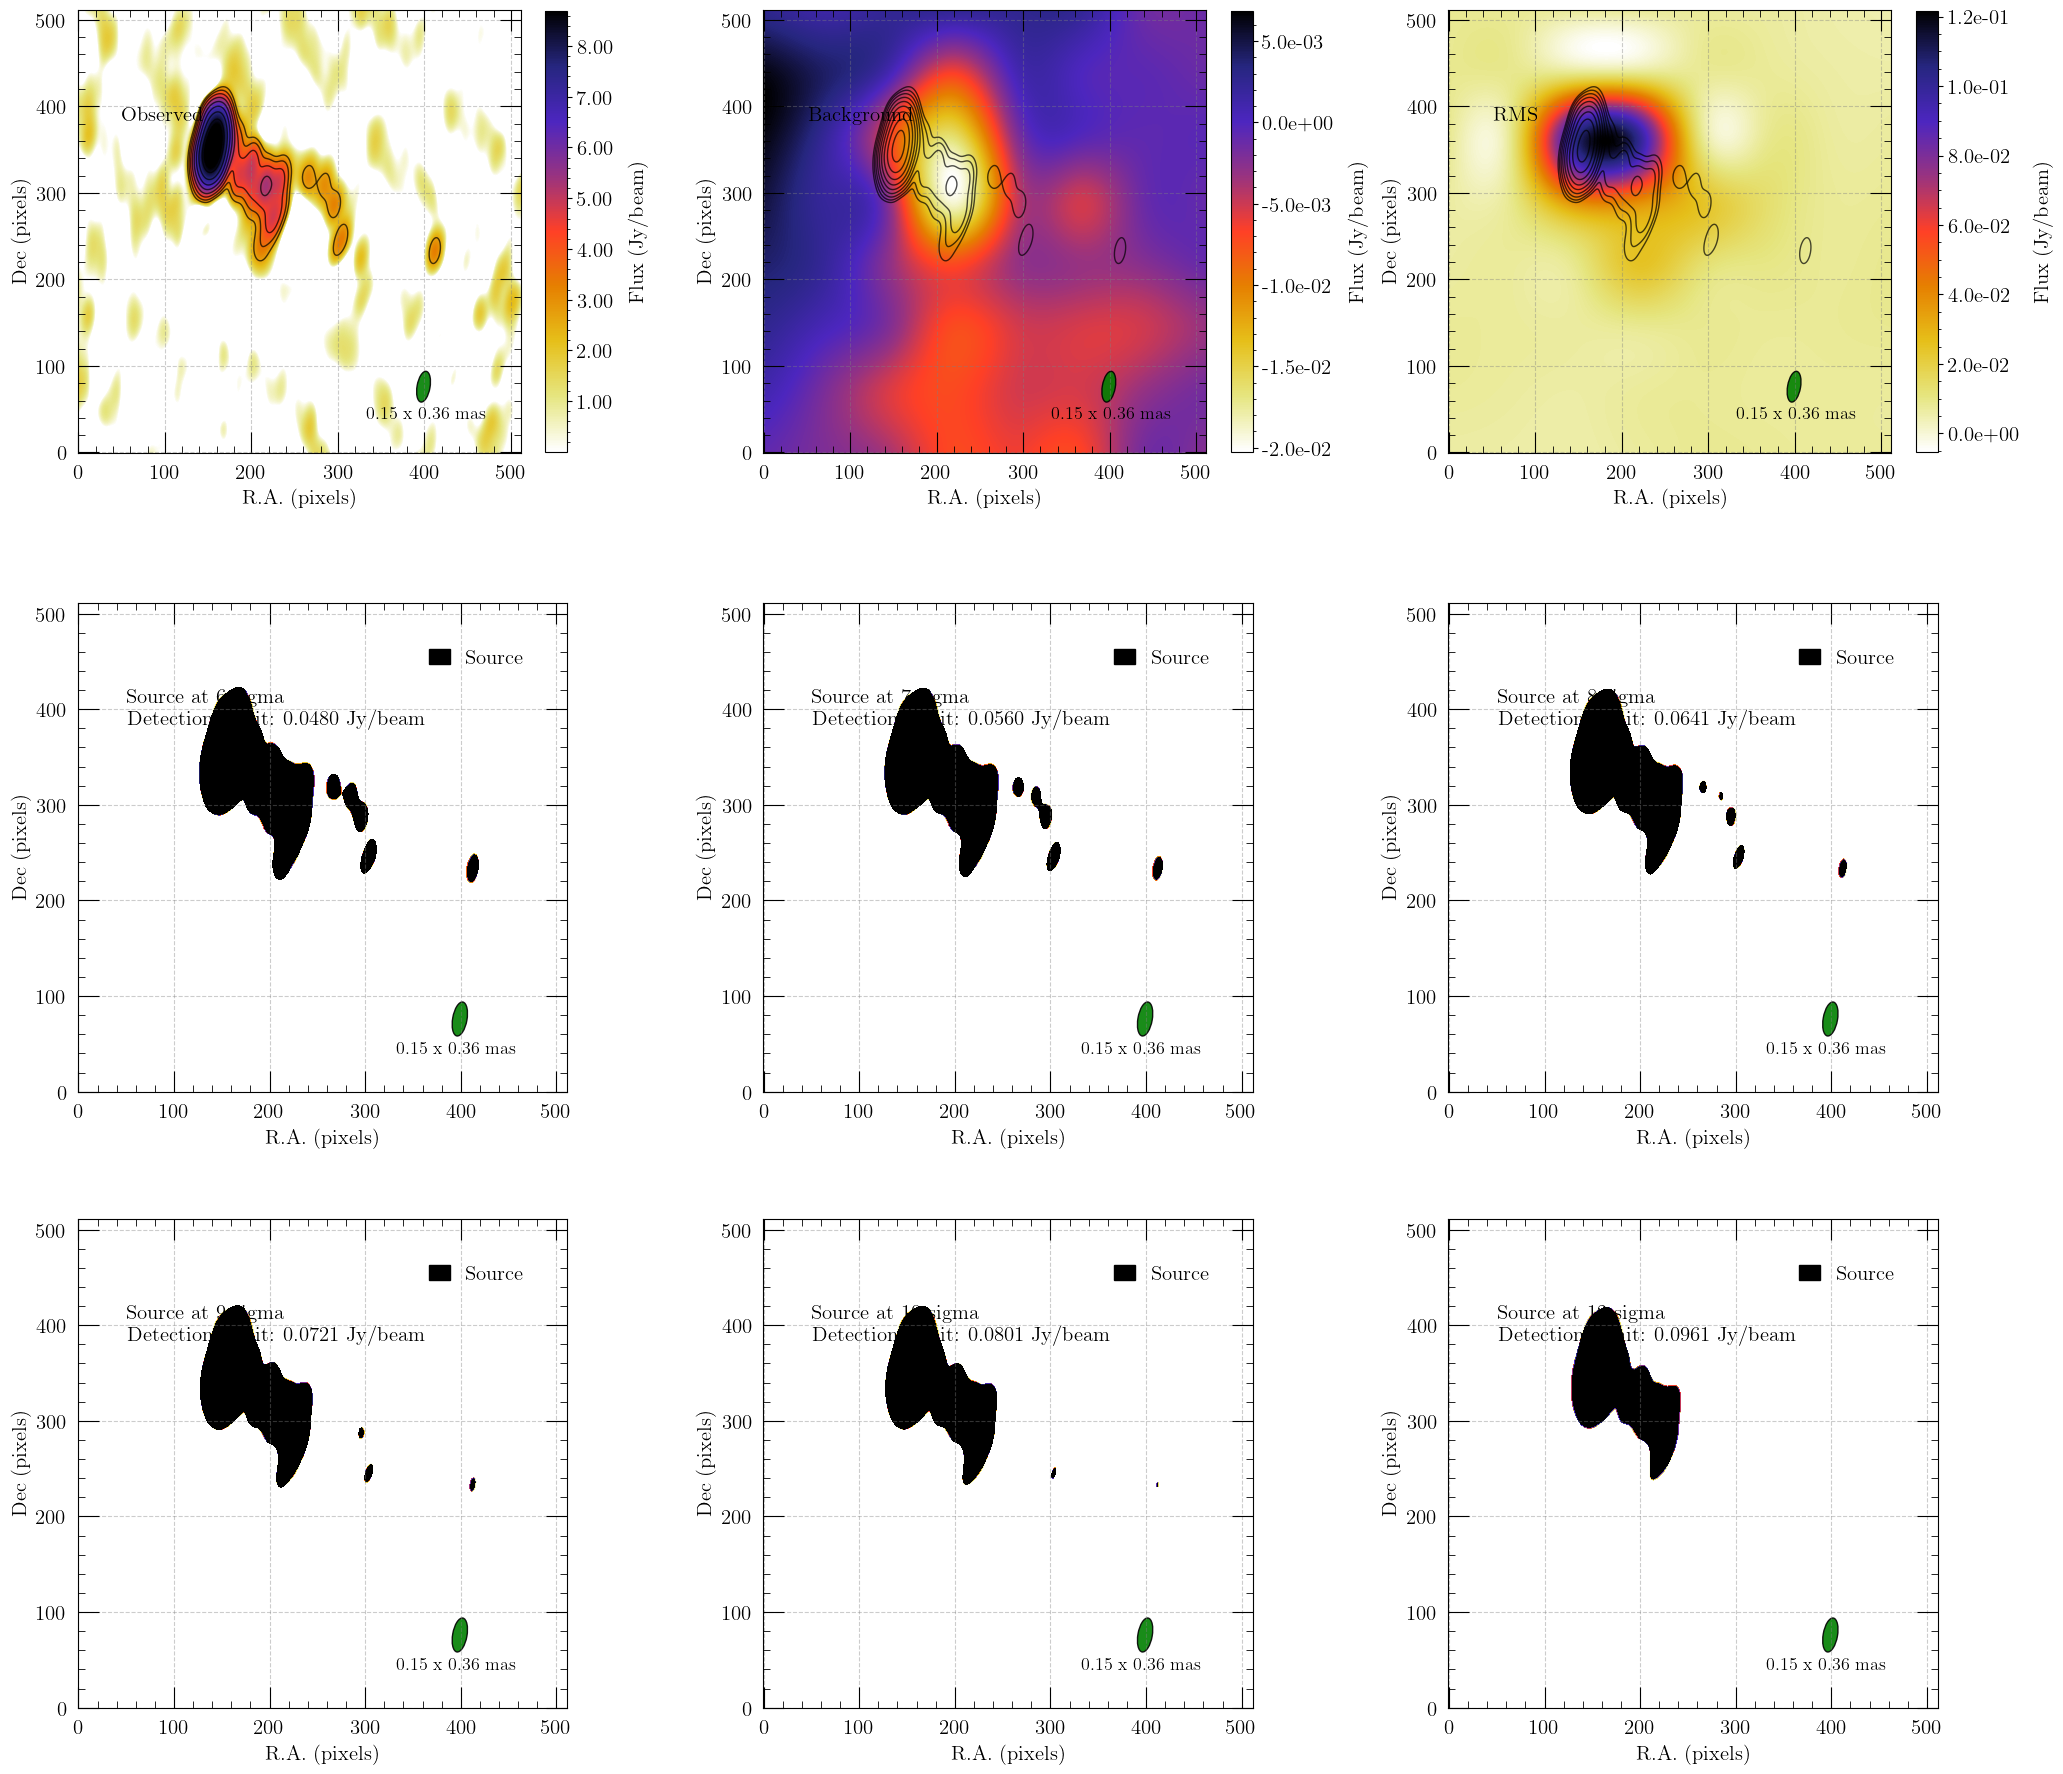

File: ../data/3C_279/2013-05-30/3C279MAY13.IMAP
Date: 2013-05-30


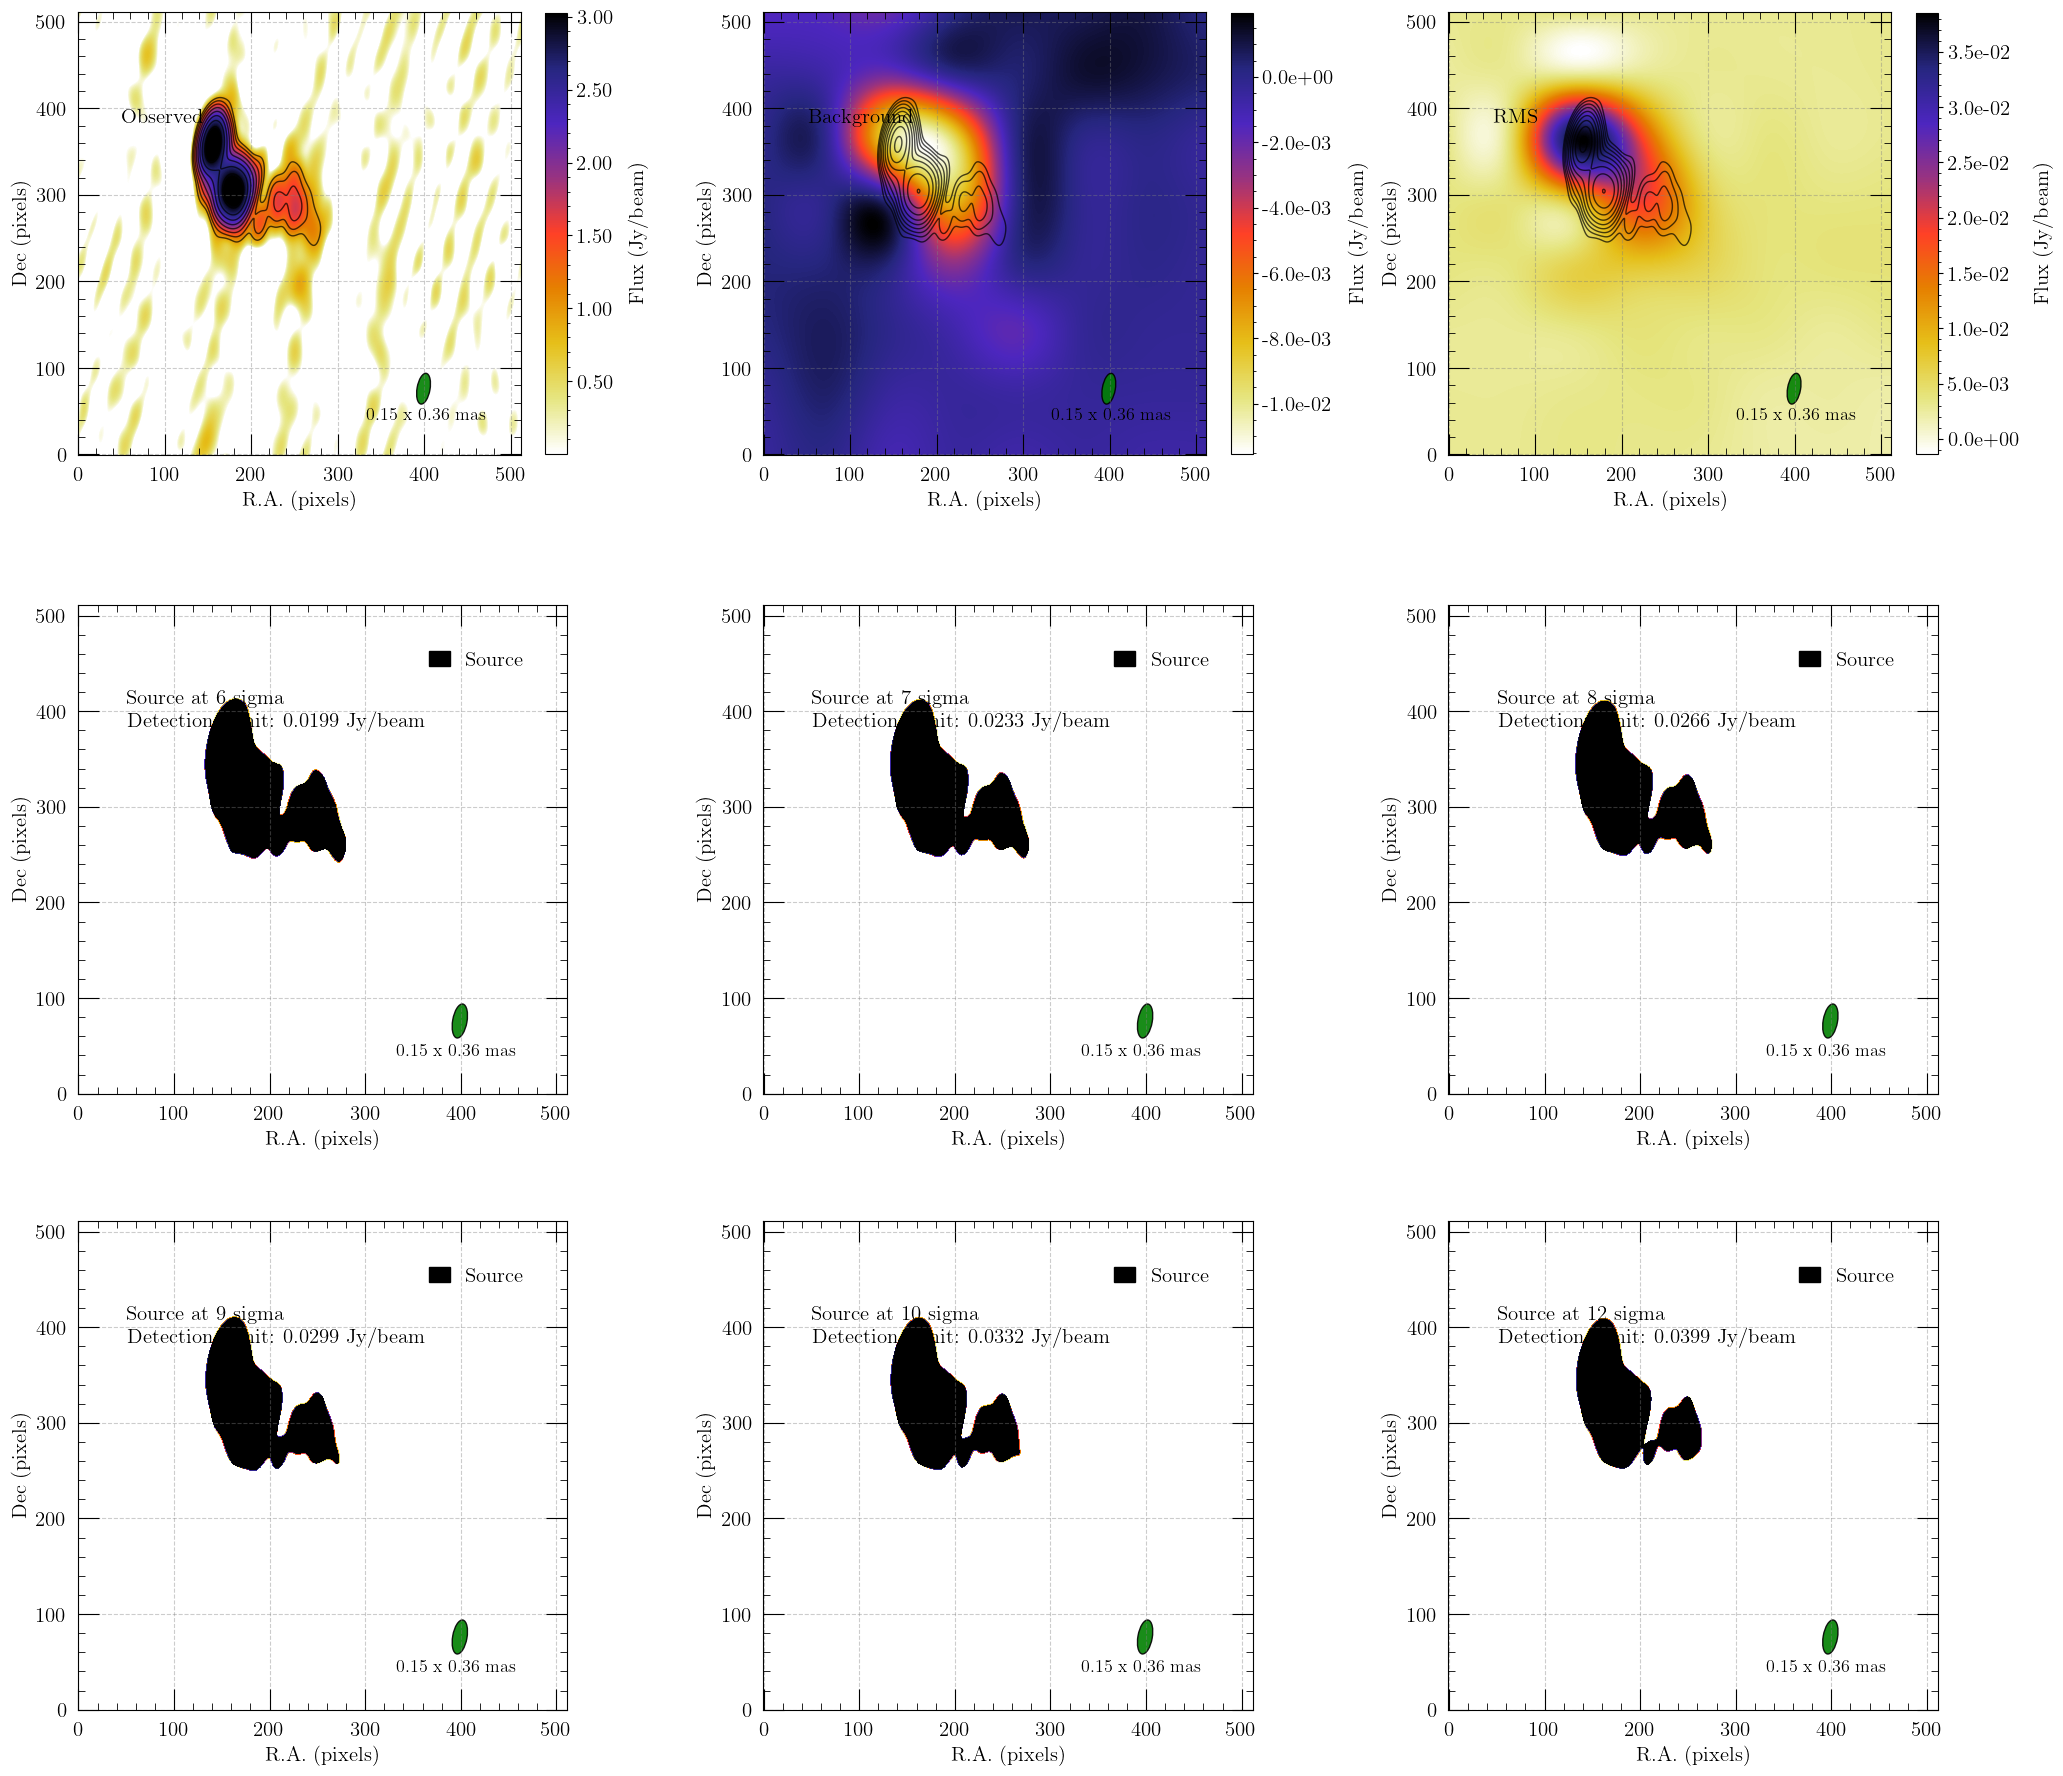

File: ../data/3C_279/2014-07-28/3C279JUL14.IMAP
Date: 2014-07-28


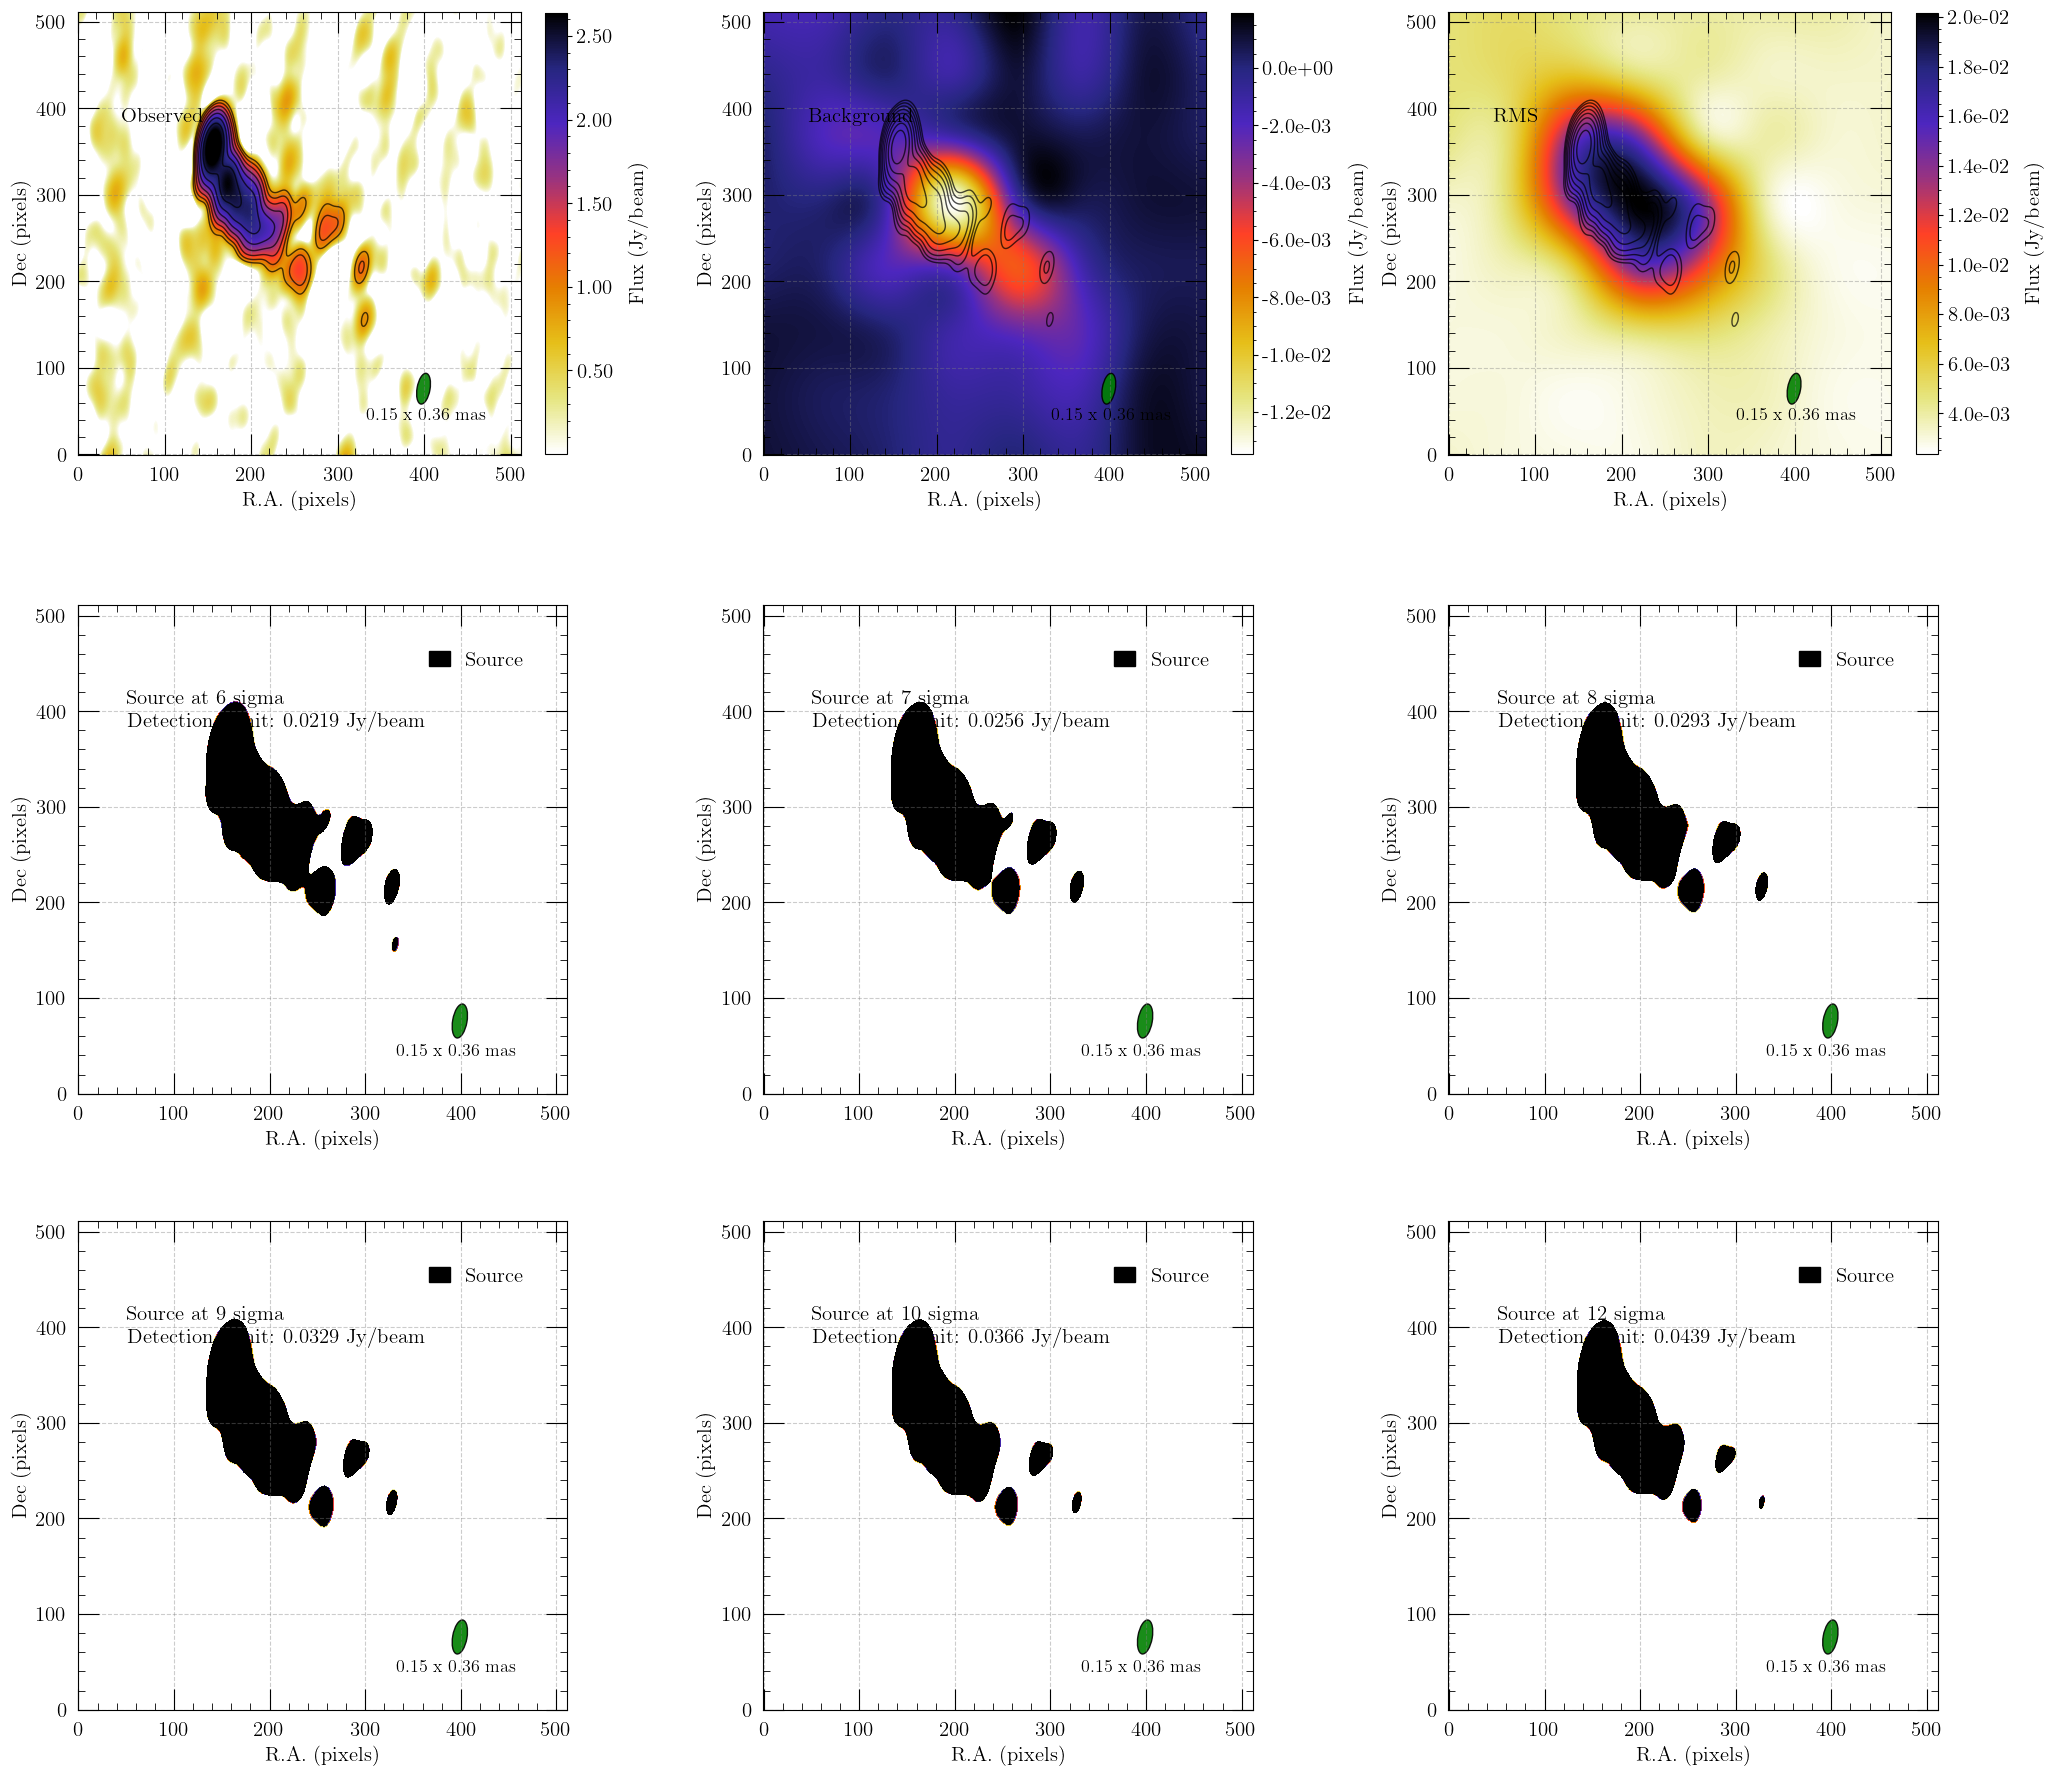

File: ../data/3C_279/2015-09-22/3C279SEP15.IMAP
Date: 2015-09-22


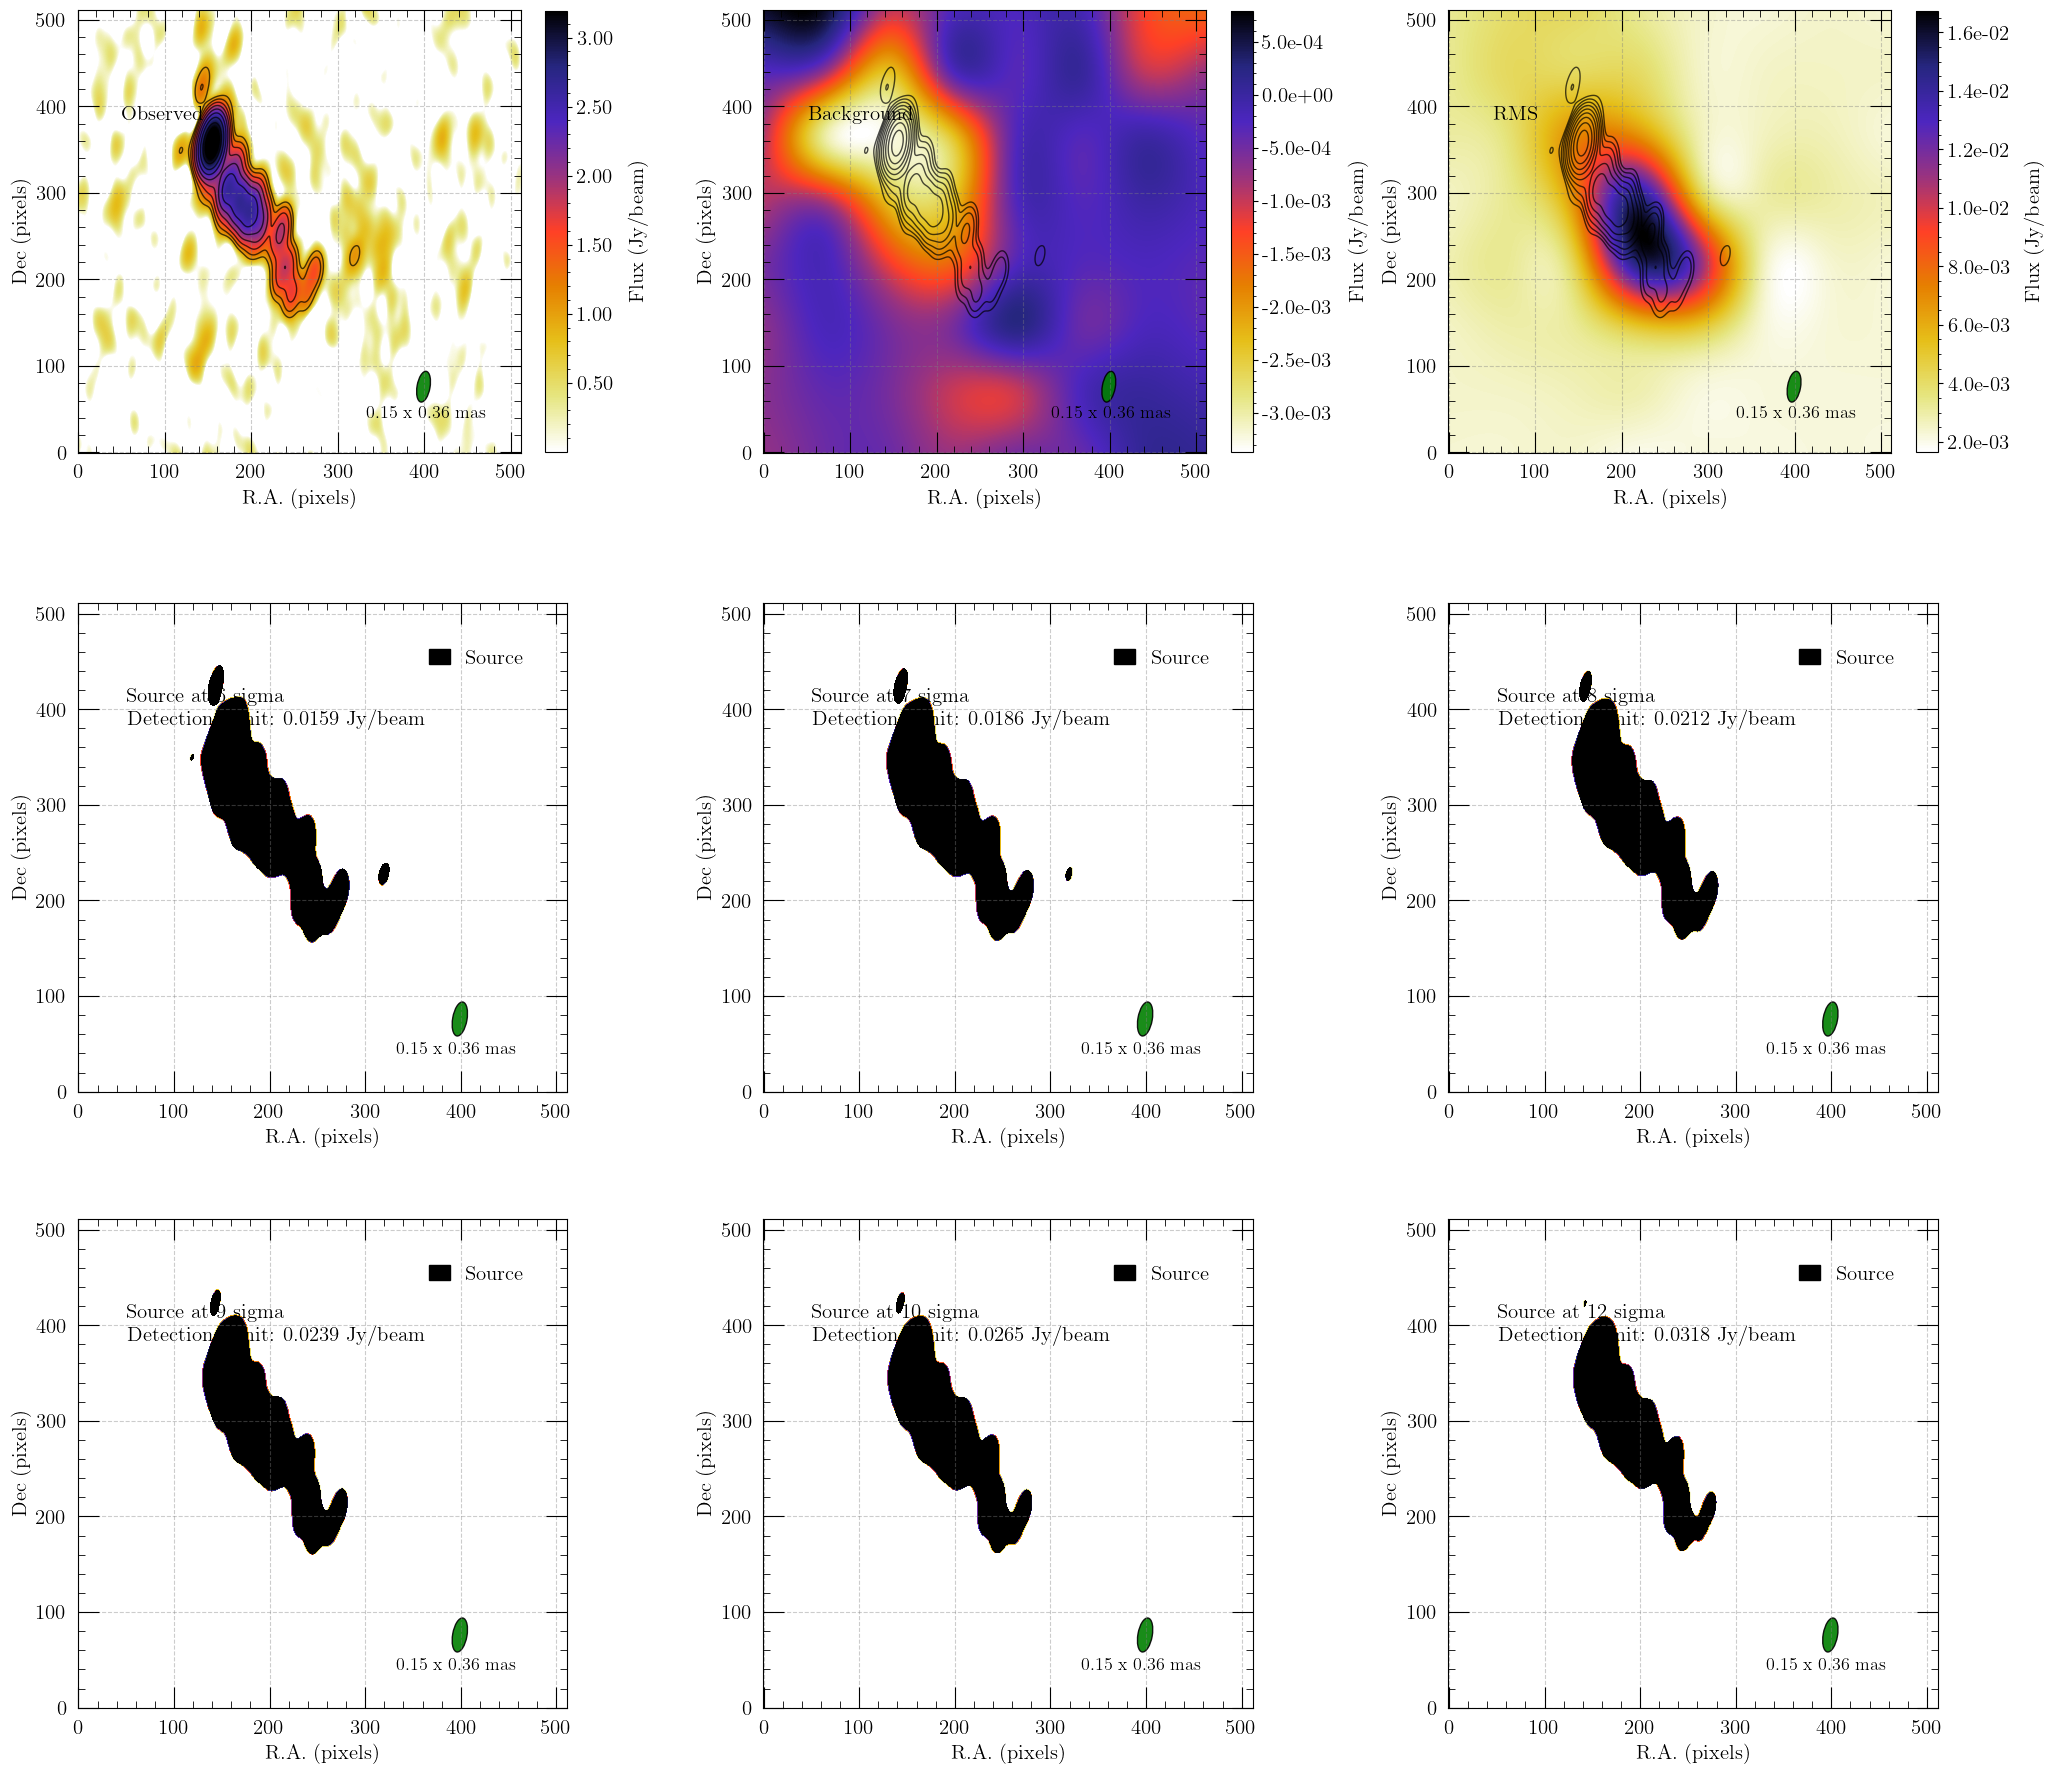

File: ../data/3C_279/2016-07-31/3C279AUG16.IMAP
Date: 2016-07-31


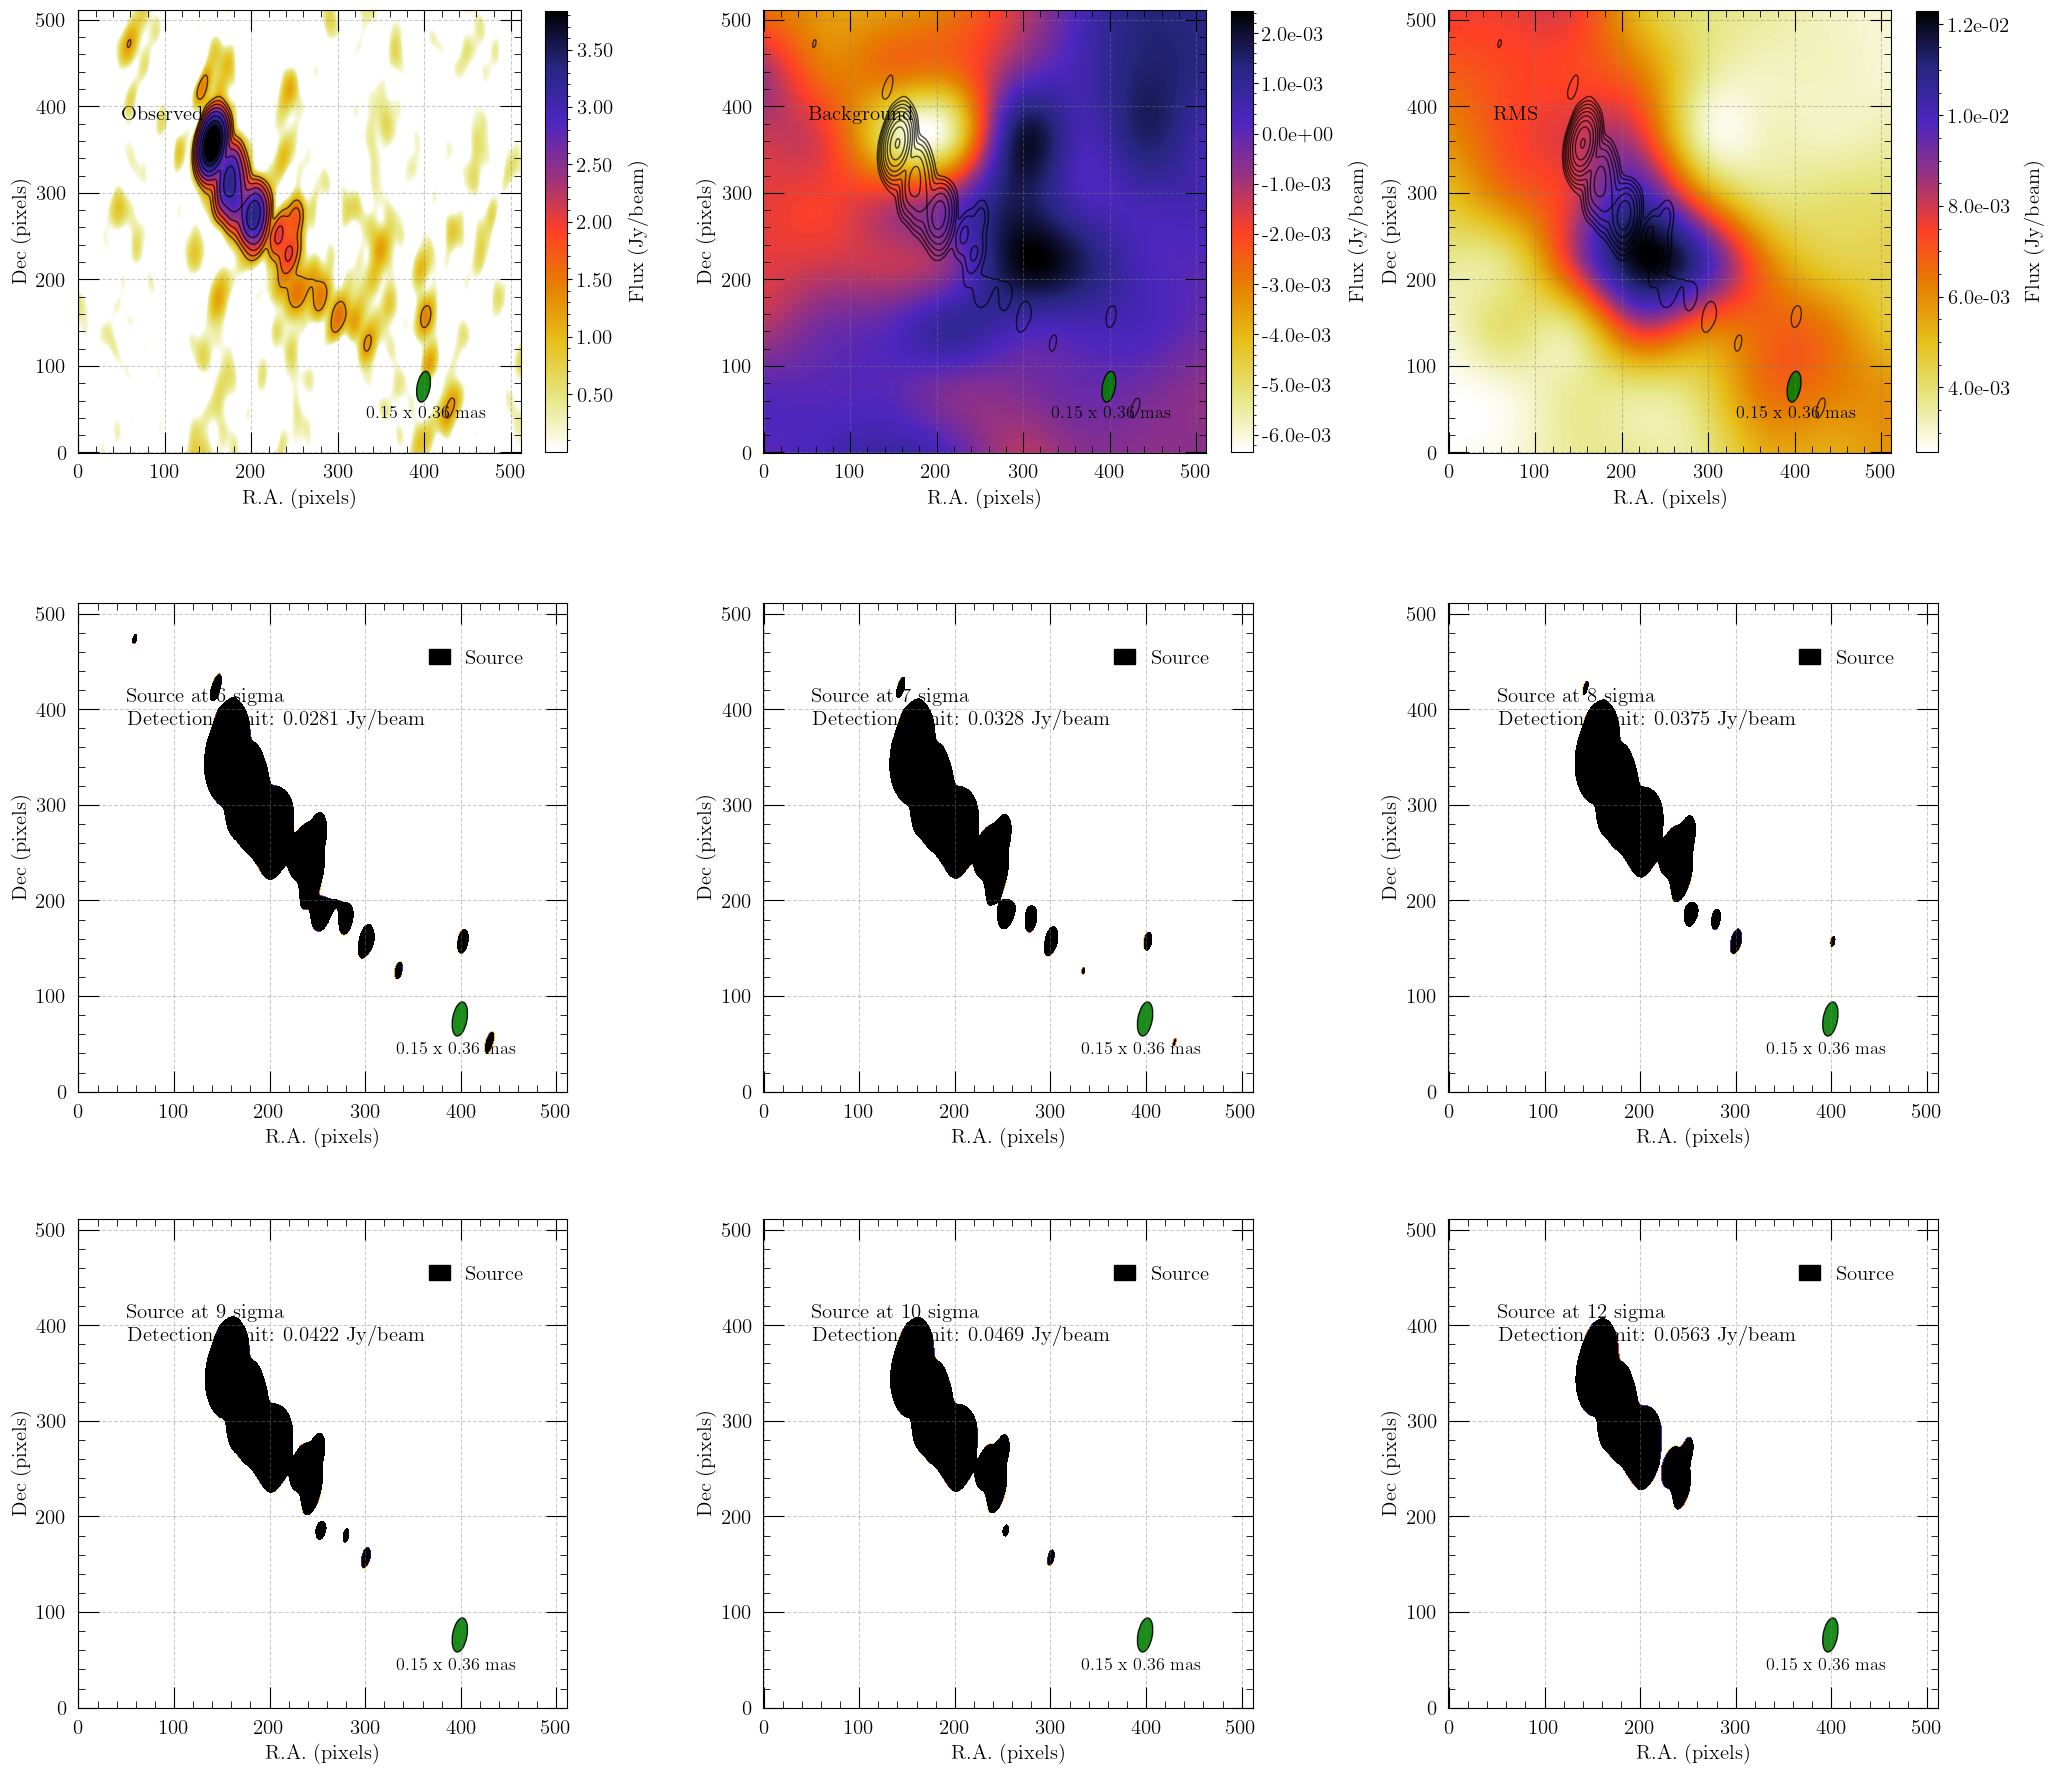

File: ../data/3C_279/2017-03-19/3C279MAR17.IMAP
Date: 2017-03-19


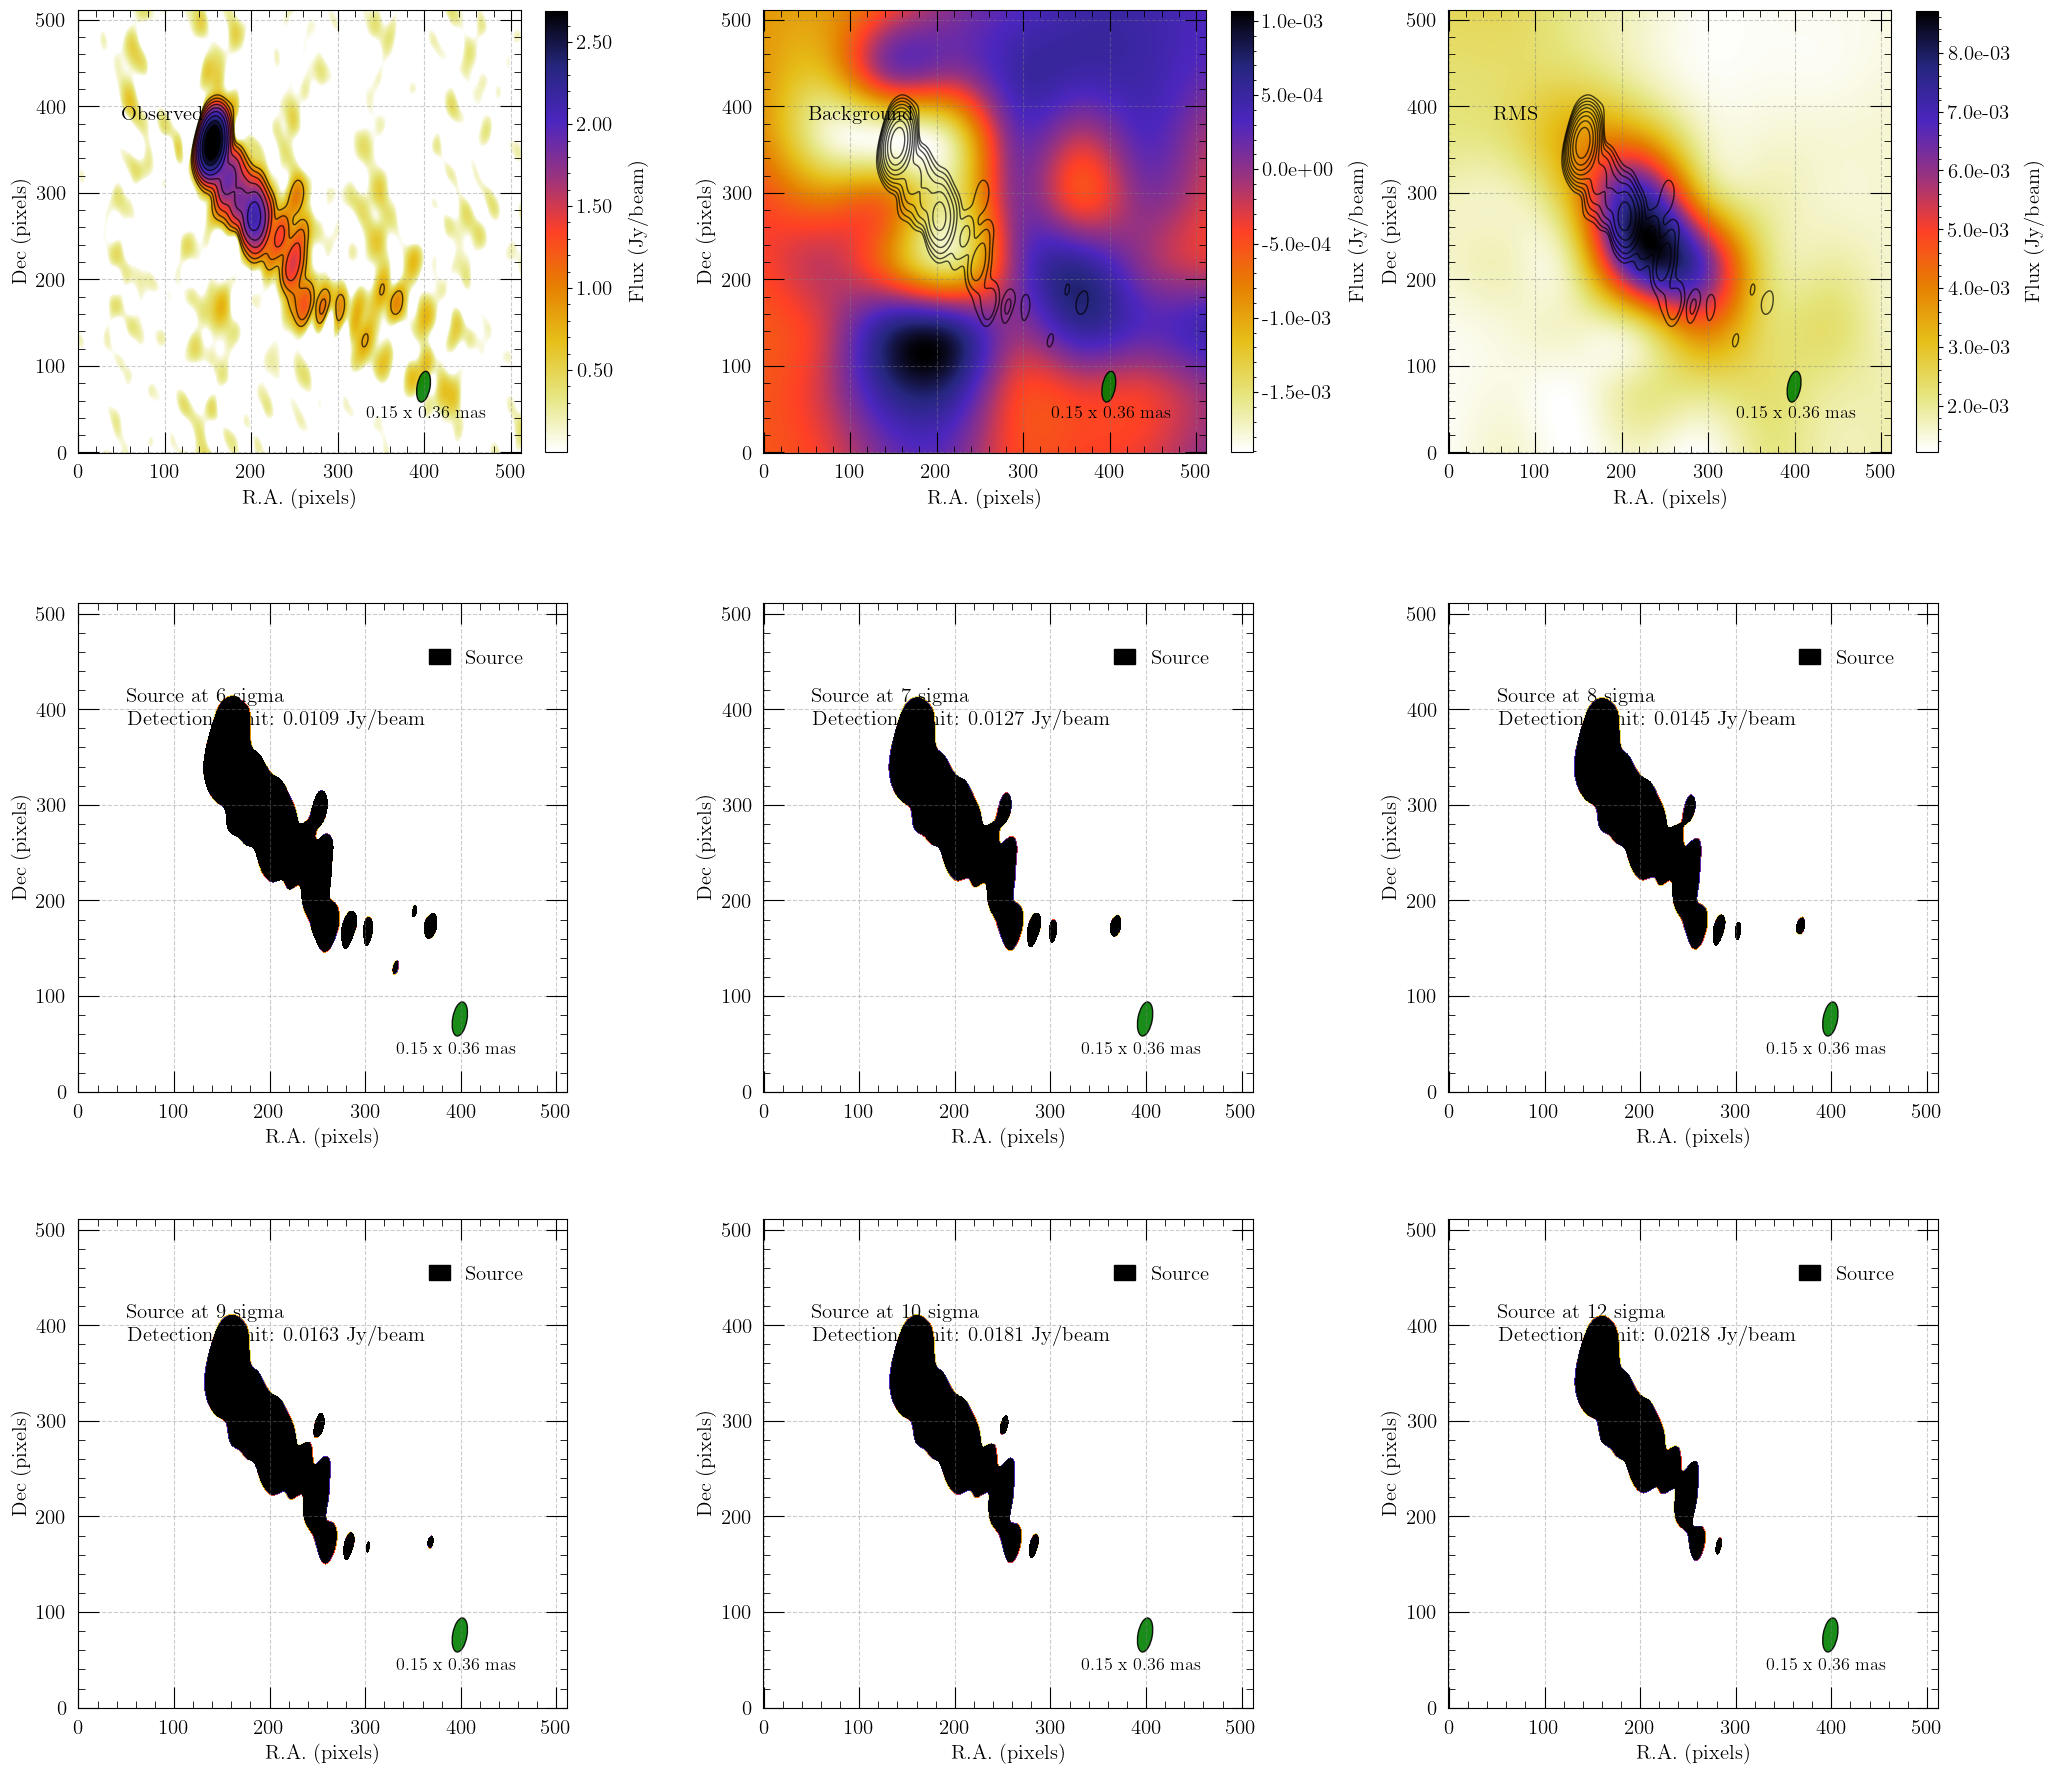

In [3]:
files_path,folders_path = files_3C279,folders_3C279

for m,(file,folder) in enumerate(zip(files_path,folders_path)):
    #Map Properties
    print(f'File: {file}')
    file_name = Path(file).stem
    hdul_map = fits.open(file) ; hdr_map = hdul_map[0].header ; date = hdr_map['DATE-OBS'] ; print(f'Date: {date}')
    map_data = hdul_map[0].data ; map_size = hdr_map['NAXIS1'] ; map_data = np.reshape(map_data,(map_size,map_size))
    delta = hdr_map['CDELT2'] ; increment = delta*3600000.0  ; c_pix = 1/increment
    f_peak = np.max(map_data)
    
    #Beam Size
    major_axis = hdr_map['BMAJ']*3600000.0 ; minor_axis = hdr_map['BMIN']*3600000.0 ; PA = (1)*hdr_map['BPA']
    
    #Detection Limit Estimation
    mmm_bkg = MMMBackground() ; sigma_clip = SigmaClip(sigma_lower=3,sigma_upper=5)
    bkg1 = Background2D(map_data,(64,64),filter_size=(3,3),sigma_clip=sigma_clip,bkg_estimator=mmm_bkg)
    bkg = bkg1.background ; bkg_median = bkg1.background_median ; bkg_err = bkg1.background_rms ; bkg_err_median = bkg1.background_rms_median
    detection_limits = {6:6*bkg_err_median,7:7*bkg_err_median,8:8*bkg_err_median,9:9*bkg_err_median,10:10*bkg_err_median,12:12*bkg_err_median}
    detection_maps = {}
    for sigma, limit in detection_limits.items():
        detection_maps[sigma] = phot.segmentation.detect_sources(map_data,limit,npixels=5)
        
    #Plot
    plt.rc('font',size=15) ; matplotlib.rcParams['font.family'] = 'Times New Roman' ;matplotlib.rcParams['text.usetex'] = True
    params = {'legend.fontsize':15,'legend.handlelength':1} ; plt.rcParams.update(params) ; colormap = 'CMRmap_r'
    Text_xy = [int((map_data.shape[1]*10)/100),int((map_data.shape[0]*75)/100)]
    Beam_xy = [int((map_data.shape[1]*78)/100),int((map_data.shape[0]*15)/100)]
    BeamText_xy = [int((map_data.shape[1]*65)/100),int((map_data.shape[0]*8)/100)]
    Data = [map_data,bkg,bkg_err]+[detection_maps[sigma] for sigma in sorted(detection_maps.keys())]
    Text_to_Plot = ['Observed','Background','RMS',*[f'Source at {sigma} sigma\nDetection Limit: {limit:.4f} Jy/beam' for sigma, limit in detection_limits.items()]]
    L1 = [detection_limits[6]/10,np.min(bkg),np.min(bkg_err)]+[0]*6 ; L2 = [f_peak/2,np.max(bkg),np.max(bkg_err)]+[1]*6

    fig, axes = plt.subplots(3,3,sharey=False,gridspec_kw={'width_ratios':[1,1,1],'height_ratios':[1,1,1]})
    fig.subplots_adjust(wspace=0.4,hspace=0.0) ; fig.set_size_inches([24,24])
    for w in range(1,10):
        axis = 'ax'+str(w) ; axis = plt.subplot(int(str(33)+str(w)))
        axis.grid(color='gray',linestyle='--',linewidth=0.8,alpha=0.4)
        axis.tick_params(which='major',top=True,right=True,direction='in',length=15,pad=8)
        axis.tick_params(which='minor',top=True,right=True,direction='in',length=5,pad=8)
        axis.minorticks_on() ; axis.set_xlabel('R.A. (pixels)') ; axis.set_ylabel('Dec (pixels)')

        beam = mpatches.Ellipse(xy=Beam_xy,width=minor_axis/increment,height=major_axis/increment,angle=PA,edgecolor='black',fc='green',lw=1,alpha=0.9)
        axis.add_patch(beam)
        axis.text(BeamText_xy[0],BeamText_xy[1],f'{minor_axis:.2f} x {major_axis:.2f} mas',fontsize=13)
        axis.text(Text_xy[0],Text_xy[1],Text_to_Plot[w-1])

        im = axis.imshow(Data[w-1],origin='lower',cmap=colormap,norm=colors.LogNorm(vmin=L1[w-1],vmax=L2[w-1]) if w == 1 else colors.Normalize(vmin=L1[w-1],vmax=L2[w-1]))
        if w < 4:
            axis.contour(map_data.data,levels=Contours(detection_limits[6],np.arange(0,10,1)),colors='black',alpha=0.7,linewidths=1.00)
            im.set_clim(L1[w-1],L2[w-1])
            cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=colormap,norm=mpl.colors.Normalize(vmin=L1[w-1],vmax=L2[w-1])),ax=axis,pad=0.05,fraction=.045)
            cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f') if w == 1 else ticker.FormatStrFormatter('%0.1e'))
            cbar.ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
            cbar.ax.tick_params(direction='out')
            cbar.set_label('Flux (Jy/beam)',labelpad=10)
        if w > 3:
            patch1 = mpatches.Patch(color='black', label='Source')
            axis.legend(handles=[patch1],framealpha=0,loc=[0.7,0.85])
    plt.savefig(f'{folder}/{file_name}_Extract.png',bbox_inches='tight',dpi=300)   
    plt.show()

#### Is up to the user to determine wich sigma for the detection limit is better and typing it in 'main_usage.ipynb' as the variable 'tresshold'.